<h1>Neural network Modeling</h1>

In [1334]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import yfinance as yf
import torch.optim as optim
#from torchviz import make_dot
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
#from torchsummary import summary
from IPython.display import Image
import plotly.graph_objects as go
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import warnings
import os
warnings.filterwarnings("ignore")
from pathlib import Path
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
import tempfile
from functools import partial
import sys

In [1335]:
# --- Imports & path setup -------------------------------------------------
import os, sys, math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Callable

np.random.seed(42); random.seed(42); torch.manual_seed(42)

# Make sure we can import hcr_nn whether we run from repo root or examples/
CWD = os.path.abspath(os.getcwd())
REPO_ROOT = os.path.abspath(os.path.join(CWD, '..')) if os.path.basename(CWD) == 'examples' else CWD
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

from hcr_nn.layers import CDFNorm
from hcr_nn.models import build_hcr_cond2d, HCRCond2D
from hcr_nn.basis import select_basis
from hcr_nn.density import conditional_density, expected_u1_given_u2
from hcr_nn.neuron import HCRNeuron

print('hcr_nn imported. Repo root =', REPO_ROOT)

hcr_nn imported. Repo root = C:\Users\adria\PycharmProjects\HCR-NN-Library\paper_stuffs\poc_stock_market


In [1336]:
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [1337]:
module_path = os.path.abspath(os.path.join('../hcr_nn/layers.py'))
if module_path not in sys.path:
    sys.path.append(module_path)

from hcr_nn.layers import *

<H2>Gathering data of CDPR stock tickers</H2>

In [1338]:
#skip ticker generation if it's present in the folder. Yahoo sometimes is too heavily occupied and cannot answer
path = './HCR-NN-Library/paper_stuffs/paper_data'

if not os.path.isfile(path):
    tck = yf.Ticker("ETH-USD")
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    df = tck.history(start=start_date, end=end_date)
    df.to_csv('../paper_data/CDPR_stock_data.csv', index=False)
else:
    df = pd.read_csv(path)

In [1339]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,13652004358,0.0,0.0
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,19740771179,0.0,0.0
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,45200463368,0.0,0.0
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,56945985763,0.0,0.0
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,41535932781,0.0,0.0


In [1340]:
#use only if first block fails for some reason
#df.to_csv('./data/prices/ticker.csv', index=False)

<h2>Drop the dividends and Stock Splits columns. We don't include them in our analysis.</h2>

In [1341]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df['Volume'] = df['Volume'].astype('float64')
columns=['Open', 'High', 'Low', 'Close', 'Volume']
df.columns == columns

array([ True,  True,  True,  True,  True])

<h2>Plot to check for missing data</h2>

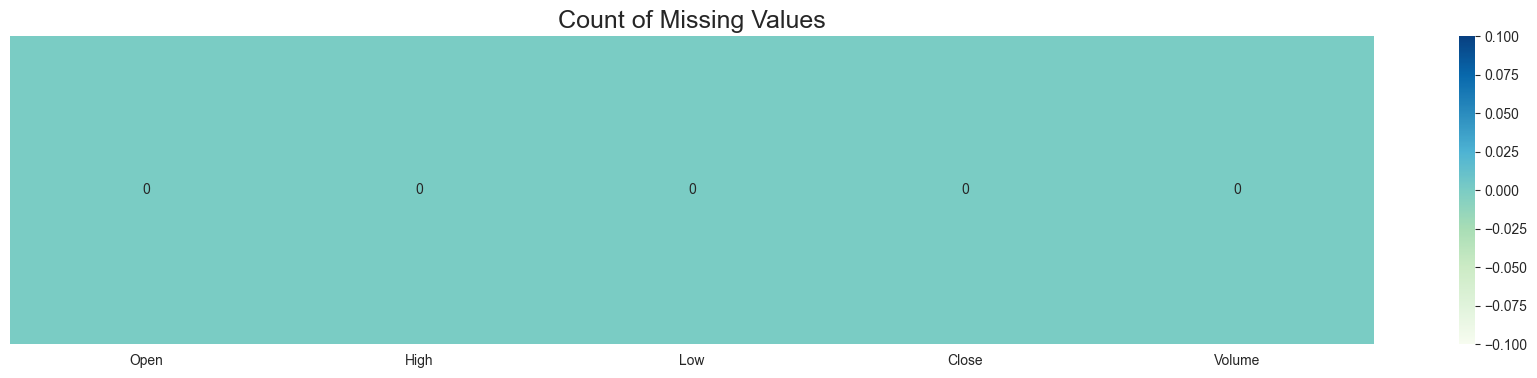

In [1342]:
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [1343]:
df.describe().T.style.background_gradient(cmap='GnBu', axis=1)

,count,mean,std,min,25%,50%,75%,max
Open,365.000000,2771.215477,1029.448767,730.402649,1886.667603,2629.748779,3632.219727,4810.071289
High,365.000000,2872.125942,1048.947824,749.201843,1959.696289,2750.534912,3827.981934,4891.704590
Low,365.000000,2658.899019,1004.316330,718.109497,1811.245850,2485.375000,3544.640381,4718.039062
Close,365.000000,2778.354149,1023.543690,730.367554,1895.552124,2633.518311,3638.122070,4812.087402
Volume,365.000000,27280819104.775341,11663121397.180578,10894785525.000000,18991302378.000000,23868866254.000000,32275969215.000000,84482912776.000000


<h2>Visualizing data.</h2>

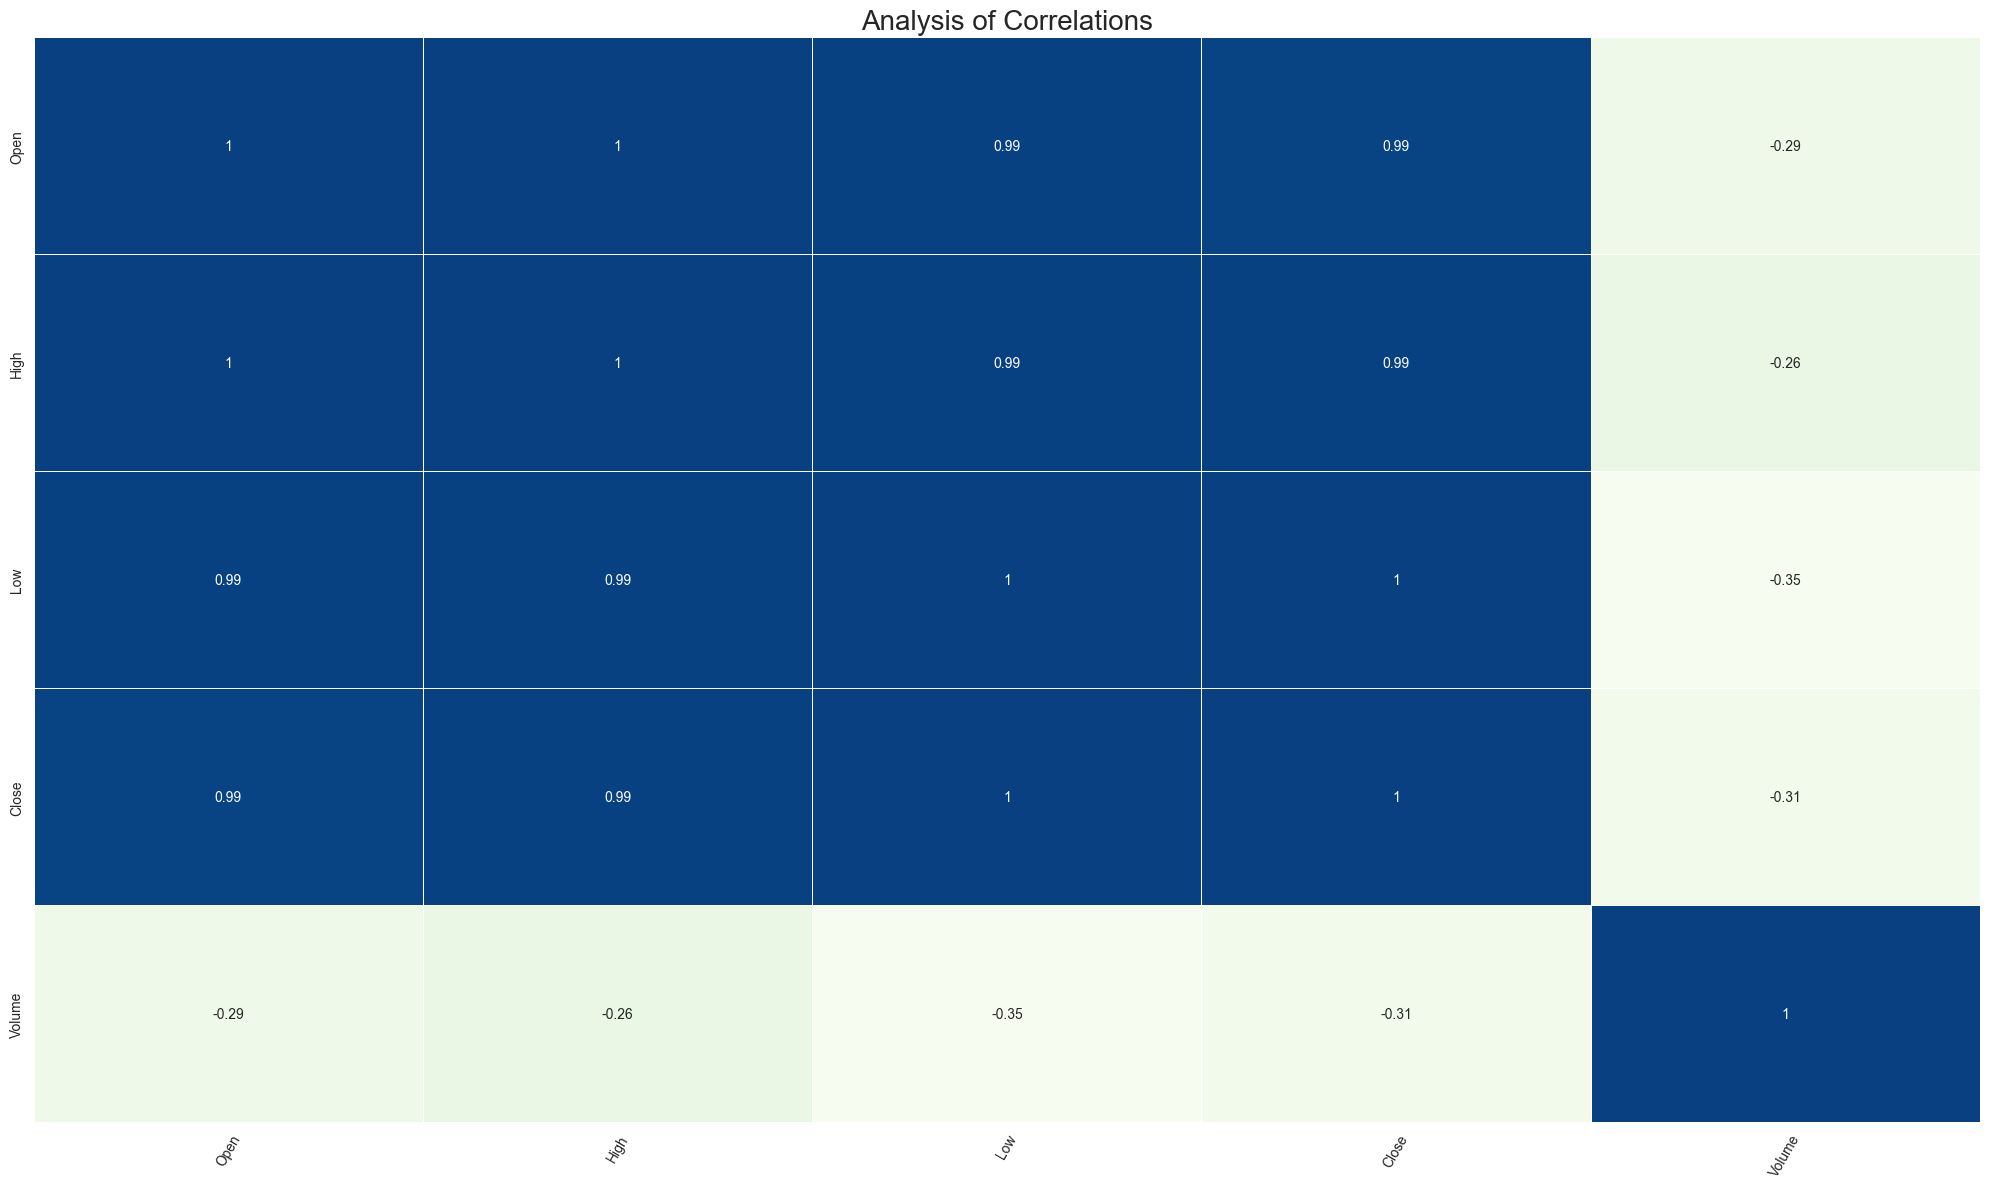

In [1344]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(numeric_only=True), cmap="GnBu", annot=True, linewidths=.6 , cbar = False)
plt.xticks(rotation=60, size=10)
plt.yticks(size=10)
plt.title('Analysis of Correlations', size=20)
plt.tight_layout()
plt.show()

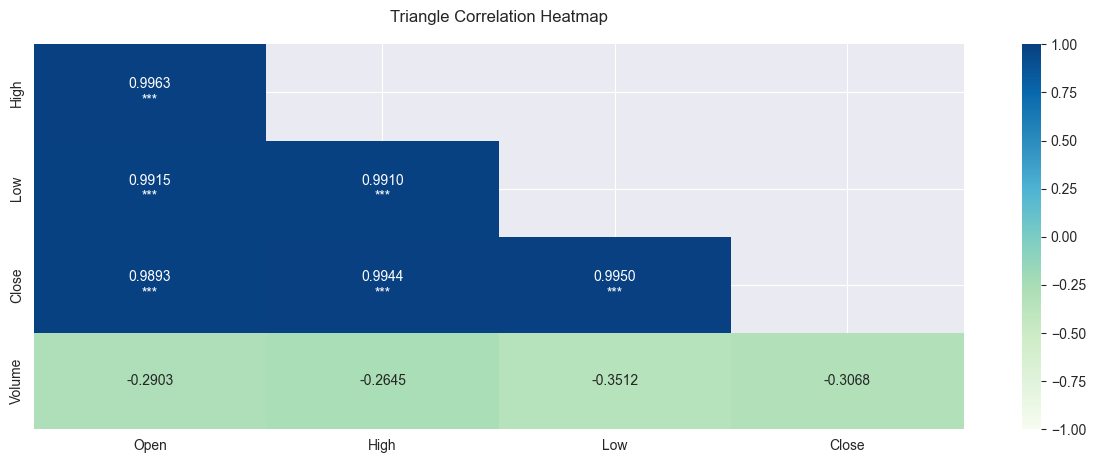

In [1345]:
corr = df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='GnBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 12}, pad=16)
plt.show()

<h2>Further analysis confirms strong correlation between prices. However the correlation between them and volume remains weak. It also further confirms multimodal distribution.<h2>

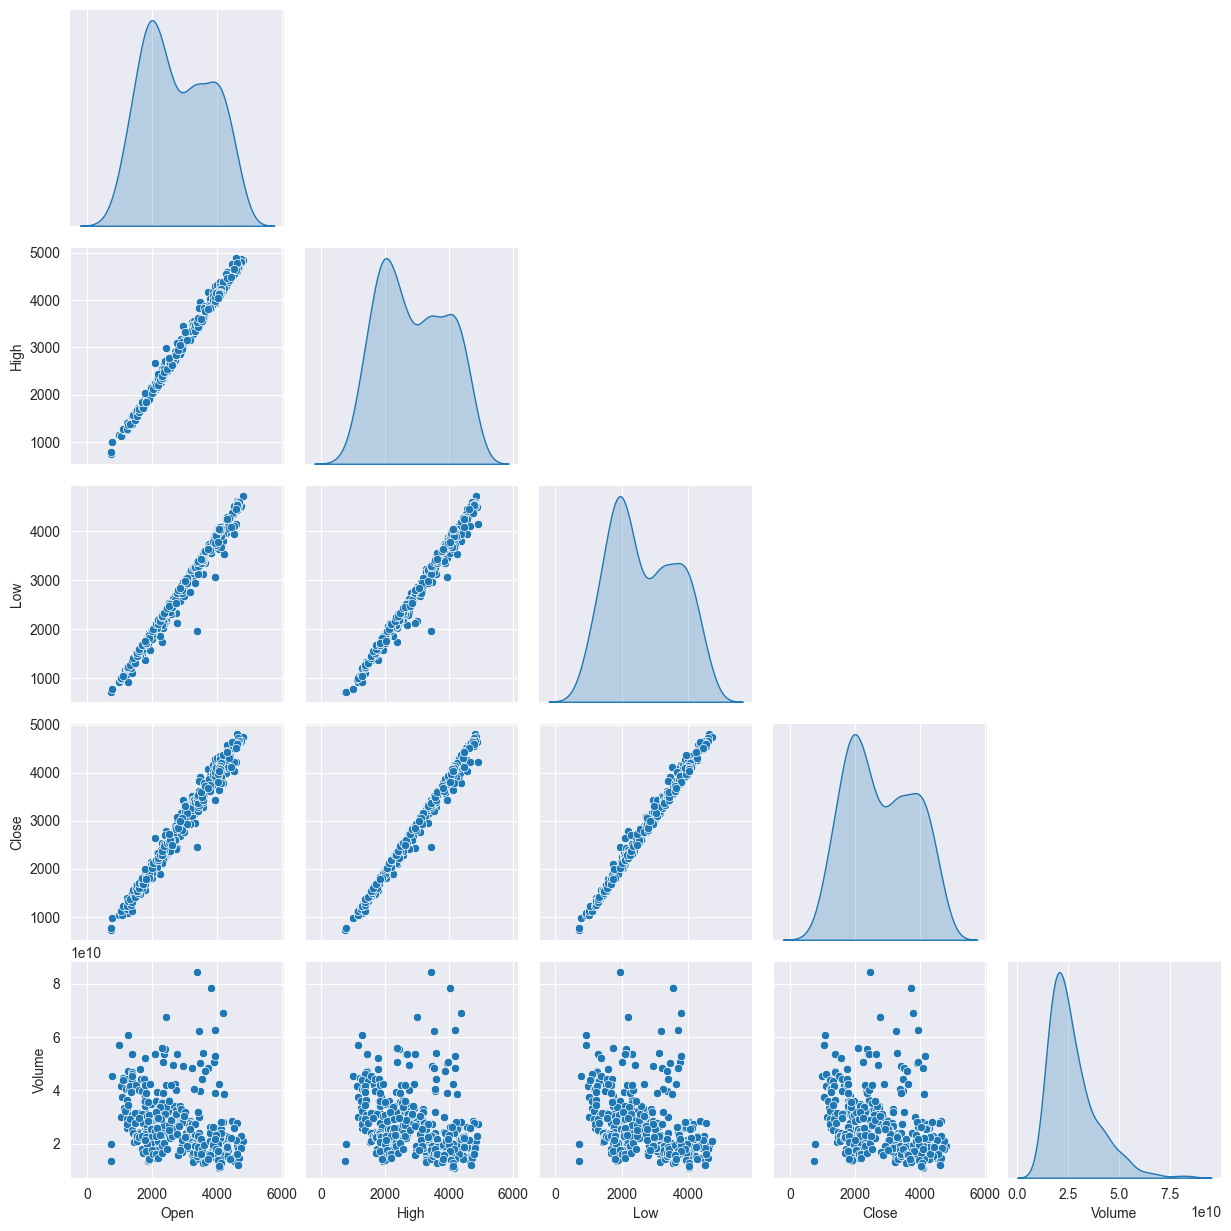

In [1346]:
custom_palette = sns.color_palette(['#2a9d8f', '#f4a261'])
sns.pairplot(data=df, diag_kind='kde', palette=custom_palette,corner=True)
plt.gcf().set_facecolor('#ffffff')
plt.show()

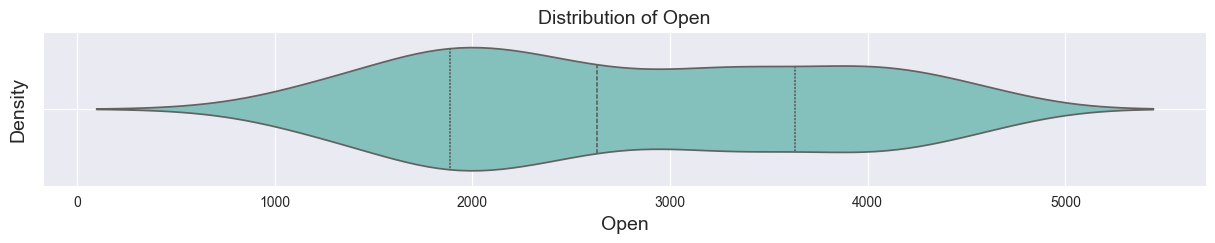

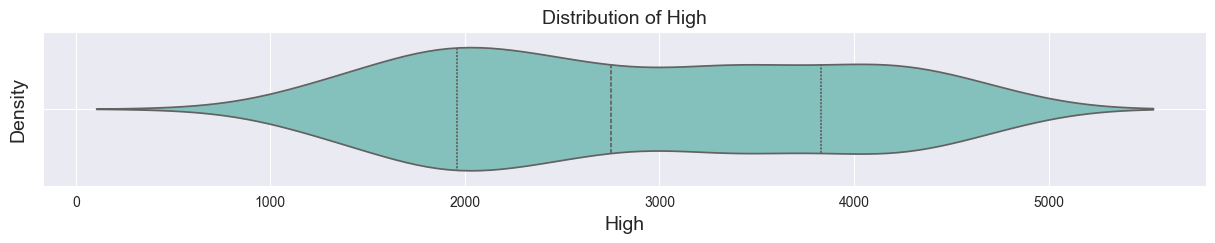

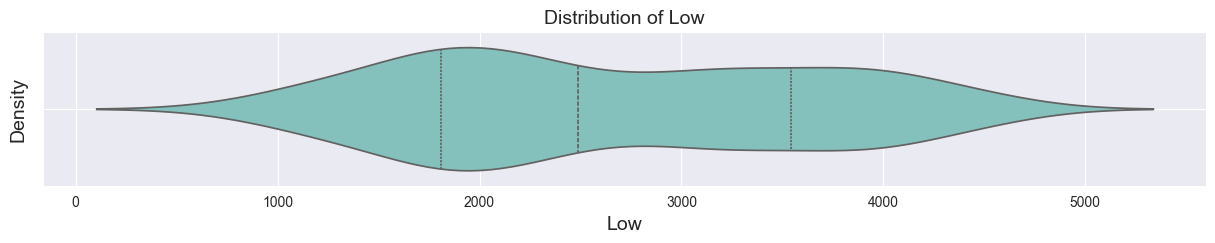

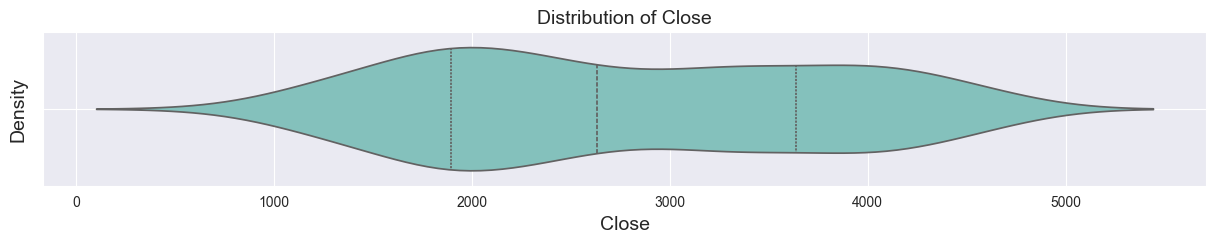

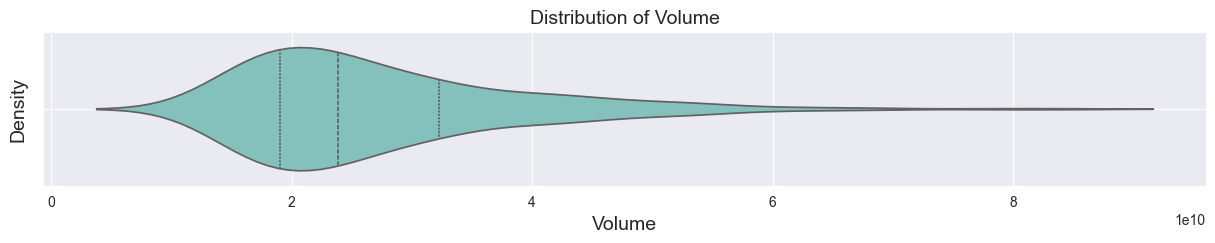

In [1347]:
palette = "GnBu"
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.violinplot(x=df[column], palette=palette, inner="quartile")  
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True)
    plt.show()

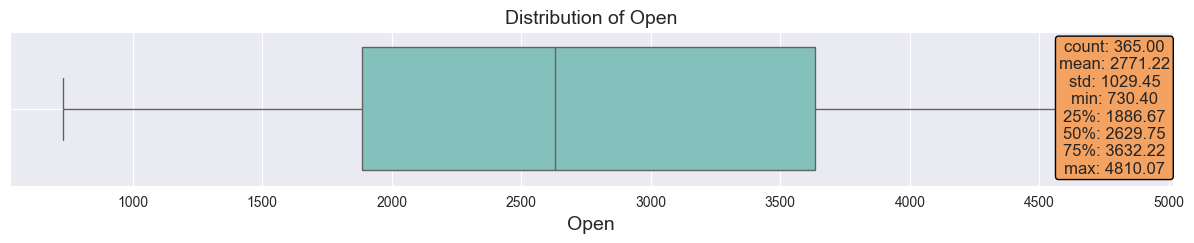

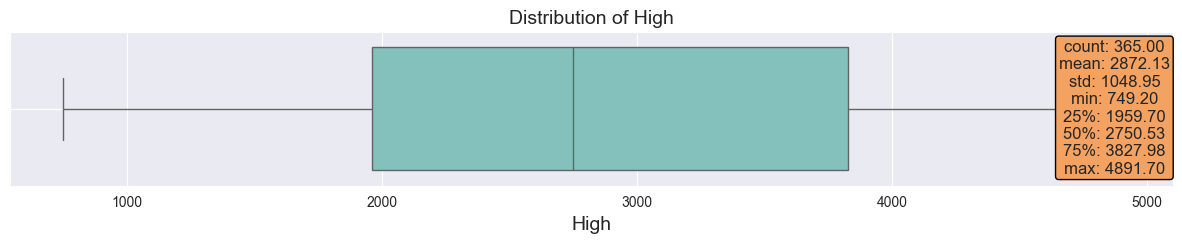

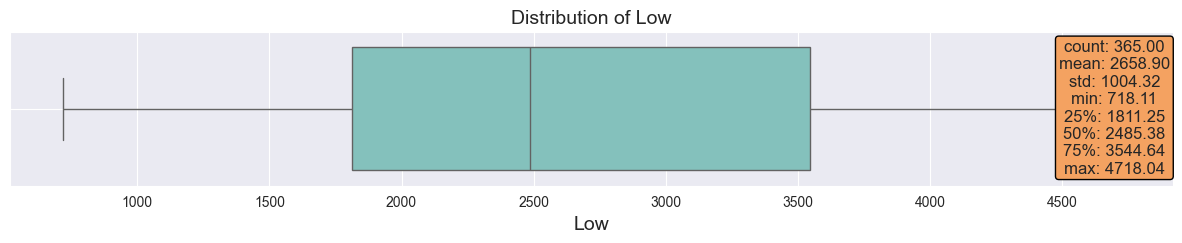

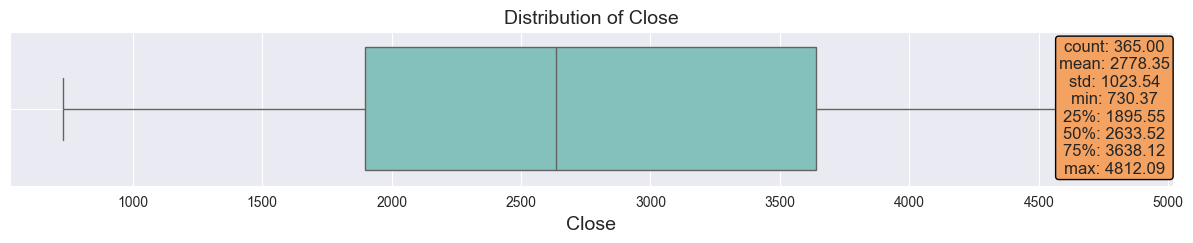

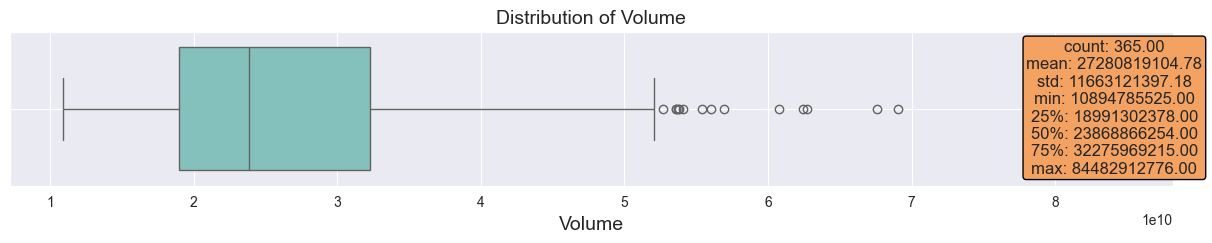

In [1348]:
palette = "GnBu" 
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.boxplot(x=df[column], palette=palette)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    stats = df[column].describe()
    stats_text = "\n".join([f"{key}: {value:.2f}" for key, value in stats.items()])
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', 
             horizontalalignment='center', bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='#f4a261'))
    plt.grid(True) 
    plt.show()

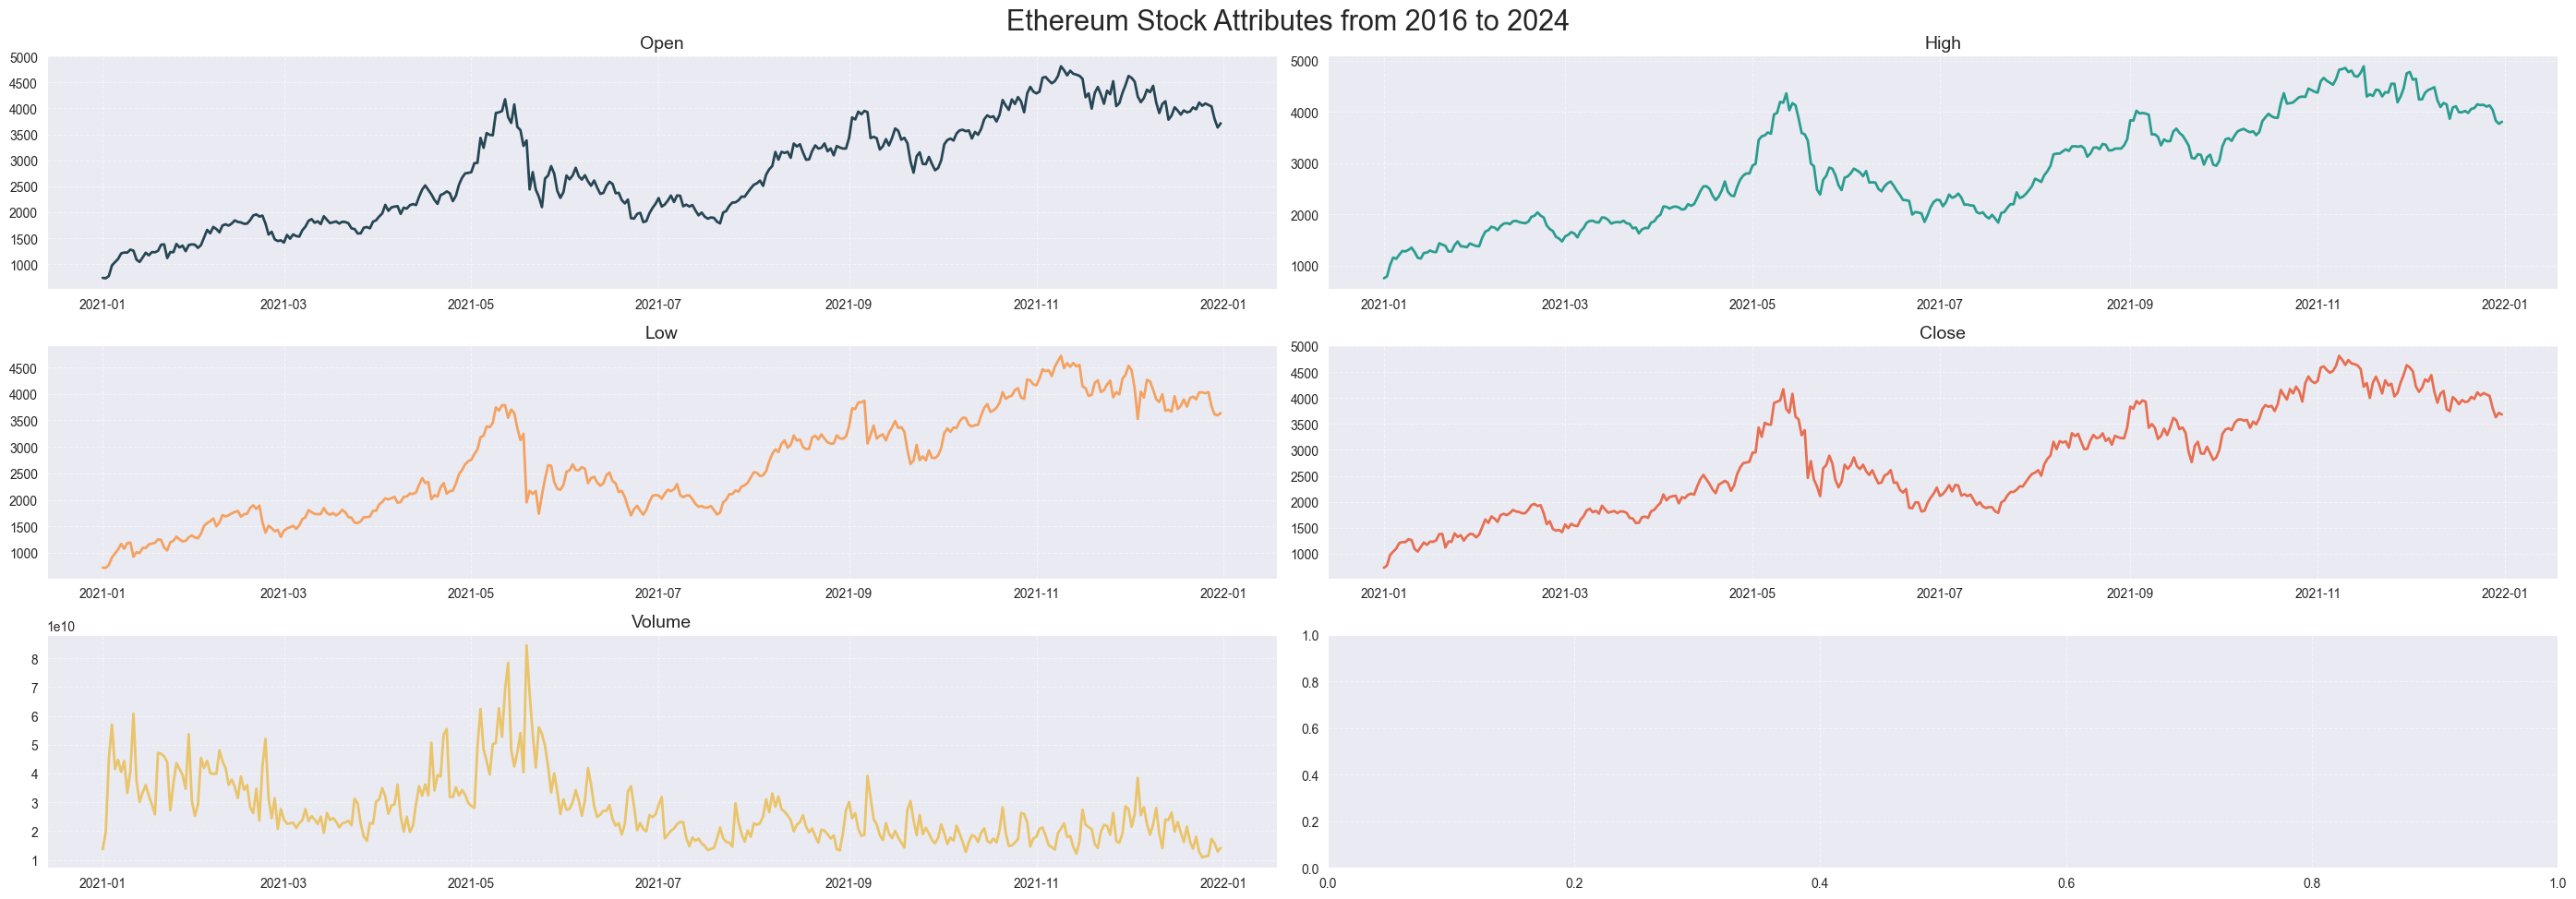

In [1349]:
import matplotlib.pyplot as plt
x=df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a', '#e9d8a6']
plt.figure(figsize=(28, 10))
plt.subplot(3, 2, 1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 2)
plt.plot(x, df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 6)
plt.grid(True, linestyle='--', alpha=0.5)
plt.suptitle('Ethereum Stock Attributes from 2016 to 2024', fontsize=22, y=0.97)
plt.tight_layout()
plt.show()


In [1350]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,1.365200e+10
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,1.974077e+10
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,4.520046e+10
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,5.694599e+10
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,4.153593e+10


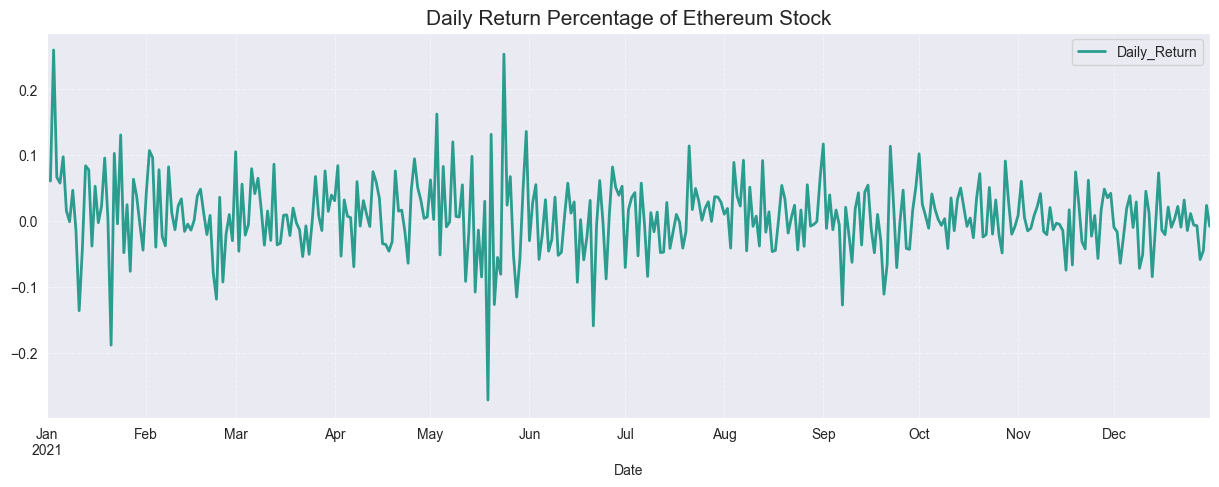

In [1351]:
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return'].plot(legend=True, figsize=(15, 5), color='#2a9d8f', linewidth=2)
plt.title('Daily Return Percentage of Ethereum Stock', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<h2>Modeling data</h2>

In [1352]:
if os.path.isfile('./data/prices/masked_ticker.csv'):
    df5 = pd.read_csv('./data/prices/masked_ticker.csv')
else:
    tck = yf.Ticker("ETH-USD")
    # defining the start date 
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    # historical data
    df5 = tck.history(start=start_date, end=end_date)
    df5 = df5.drop(['Dividends', 'Stock Splits'], axis=1)

In [1353]:
df5.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,13652004358
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,19740771179
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,45200463368
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,56945985763
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,41535932781


In [1354]:
if os.path.isfile('../paper_data/masked_ticker.csv'):
    pass
else:
    df5.to_csv('./paper_data/masked_ticker.csv')

In [1355]:
df5 = df5.reset_index()

In [1356]:
df5['Volume'] = df5['Volume'].astype('float64')

<h2>Using indicators to further analyse the data</h2>

In [1357]:
def get_tech_ind(data):
    data['MA5'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA10'] = data.iloc[:,4].rolling(window=10).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bands
    data['8SD'] = data.iloc[:, 4].rolling(8).std()
    data['upper_band'] = data['MA10'] + (data['8SD'] * 2)
    data['lower_band'] = data['MA10'] - (data['8SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    return data

In [1358]:
start_date = '2015-01-01'
end_date = '2025-01-01'

mask = (df5['Date'] >= start_date) & (df5['Date'] < end_date)

df5 = df5.loc[mask]

In [1359]:
df5.tail(3)

,Date,Open,High,Low,Close,Volume
362,2021-12-29 00:00:00+00:00,3797.436279,3827.981934,3612.795898,3628.531738,1.572256e+10
363,2021-12-30 00:00:00+00:00,3632.219727,3767.559814,3595.204834,3713.852051,1.292538e+10
364,2021-12-31 00:00:00+00:00,3713.430176,3807.288818,3636.869873,3682.632812,1.415729e+10


<h2>Appending the data from sentiment analysis file we export into the other folder.</h2>

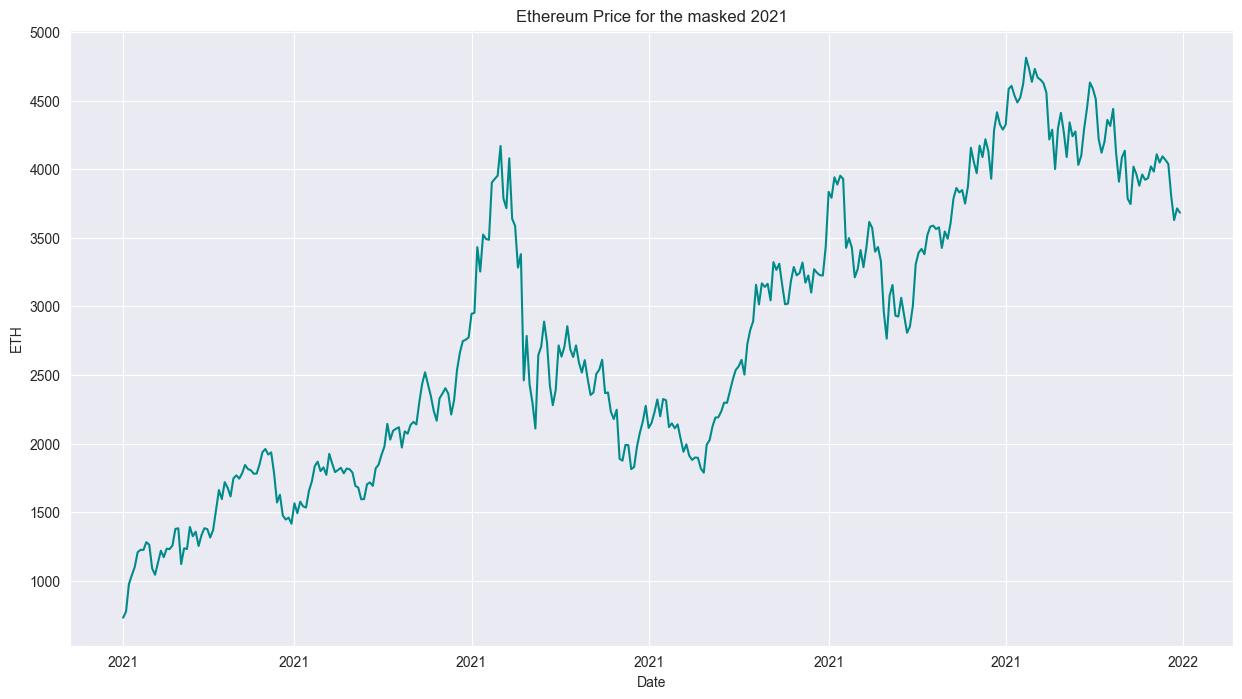

In [1360]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df5['Date'], df5['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="ETH", title="Ethereum Price for the masked 2021")

ax.xaxis.set_major_formatter(DateFormatter("%Y"))

plt.show()

In [1361]:
tech_df = get_tech_ind(df5)
dataset = tech_df.iloc[10:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,1198.637556,1118.073859,36.767167,89.245201,1296.564261,939.583456,1147.247263
1,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,1190.555908,1144.963818,26.421413,88.539272,1322.042362,967.885275,1078.038671
2,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,1179.645508,1160.486987,34.872771,85.214707,1330.916402,990.057572,1113.172499
3,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,1178.613351,1178.308984,38.569672,85.764193,1349.837370,1006.780598,1183.359516
4,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,1171.132987,1185.491833,22.663302,84.168607,1353.829048,1017.154619,1175.676235


In [1362]:
df5['Date'] = pd.to_datetime(df5['Date'], utc=True)

<h2>Visualize the indicators</h2>

In [1363]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA5'], label='Moving Average (5 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA10'], label='Moving Average (10 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['8SD'], label='Moving Average (8 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['EMA'], label='Exponential Moving Average (8 days)', color='r', linestyle='-.')
    
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

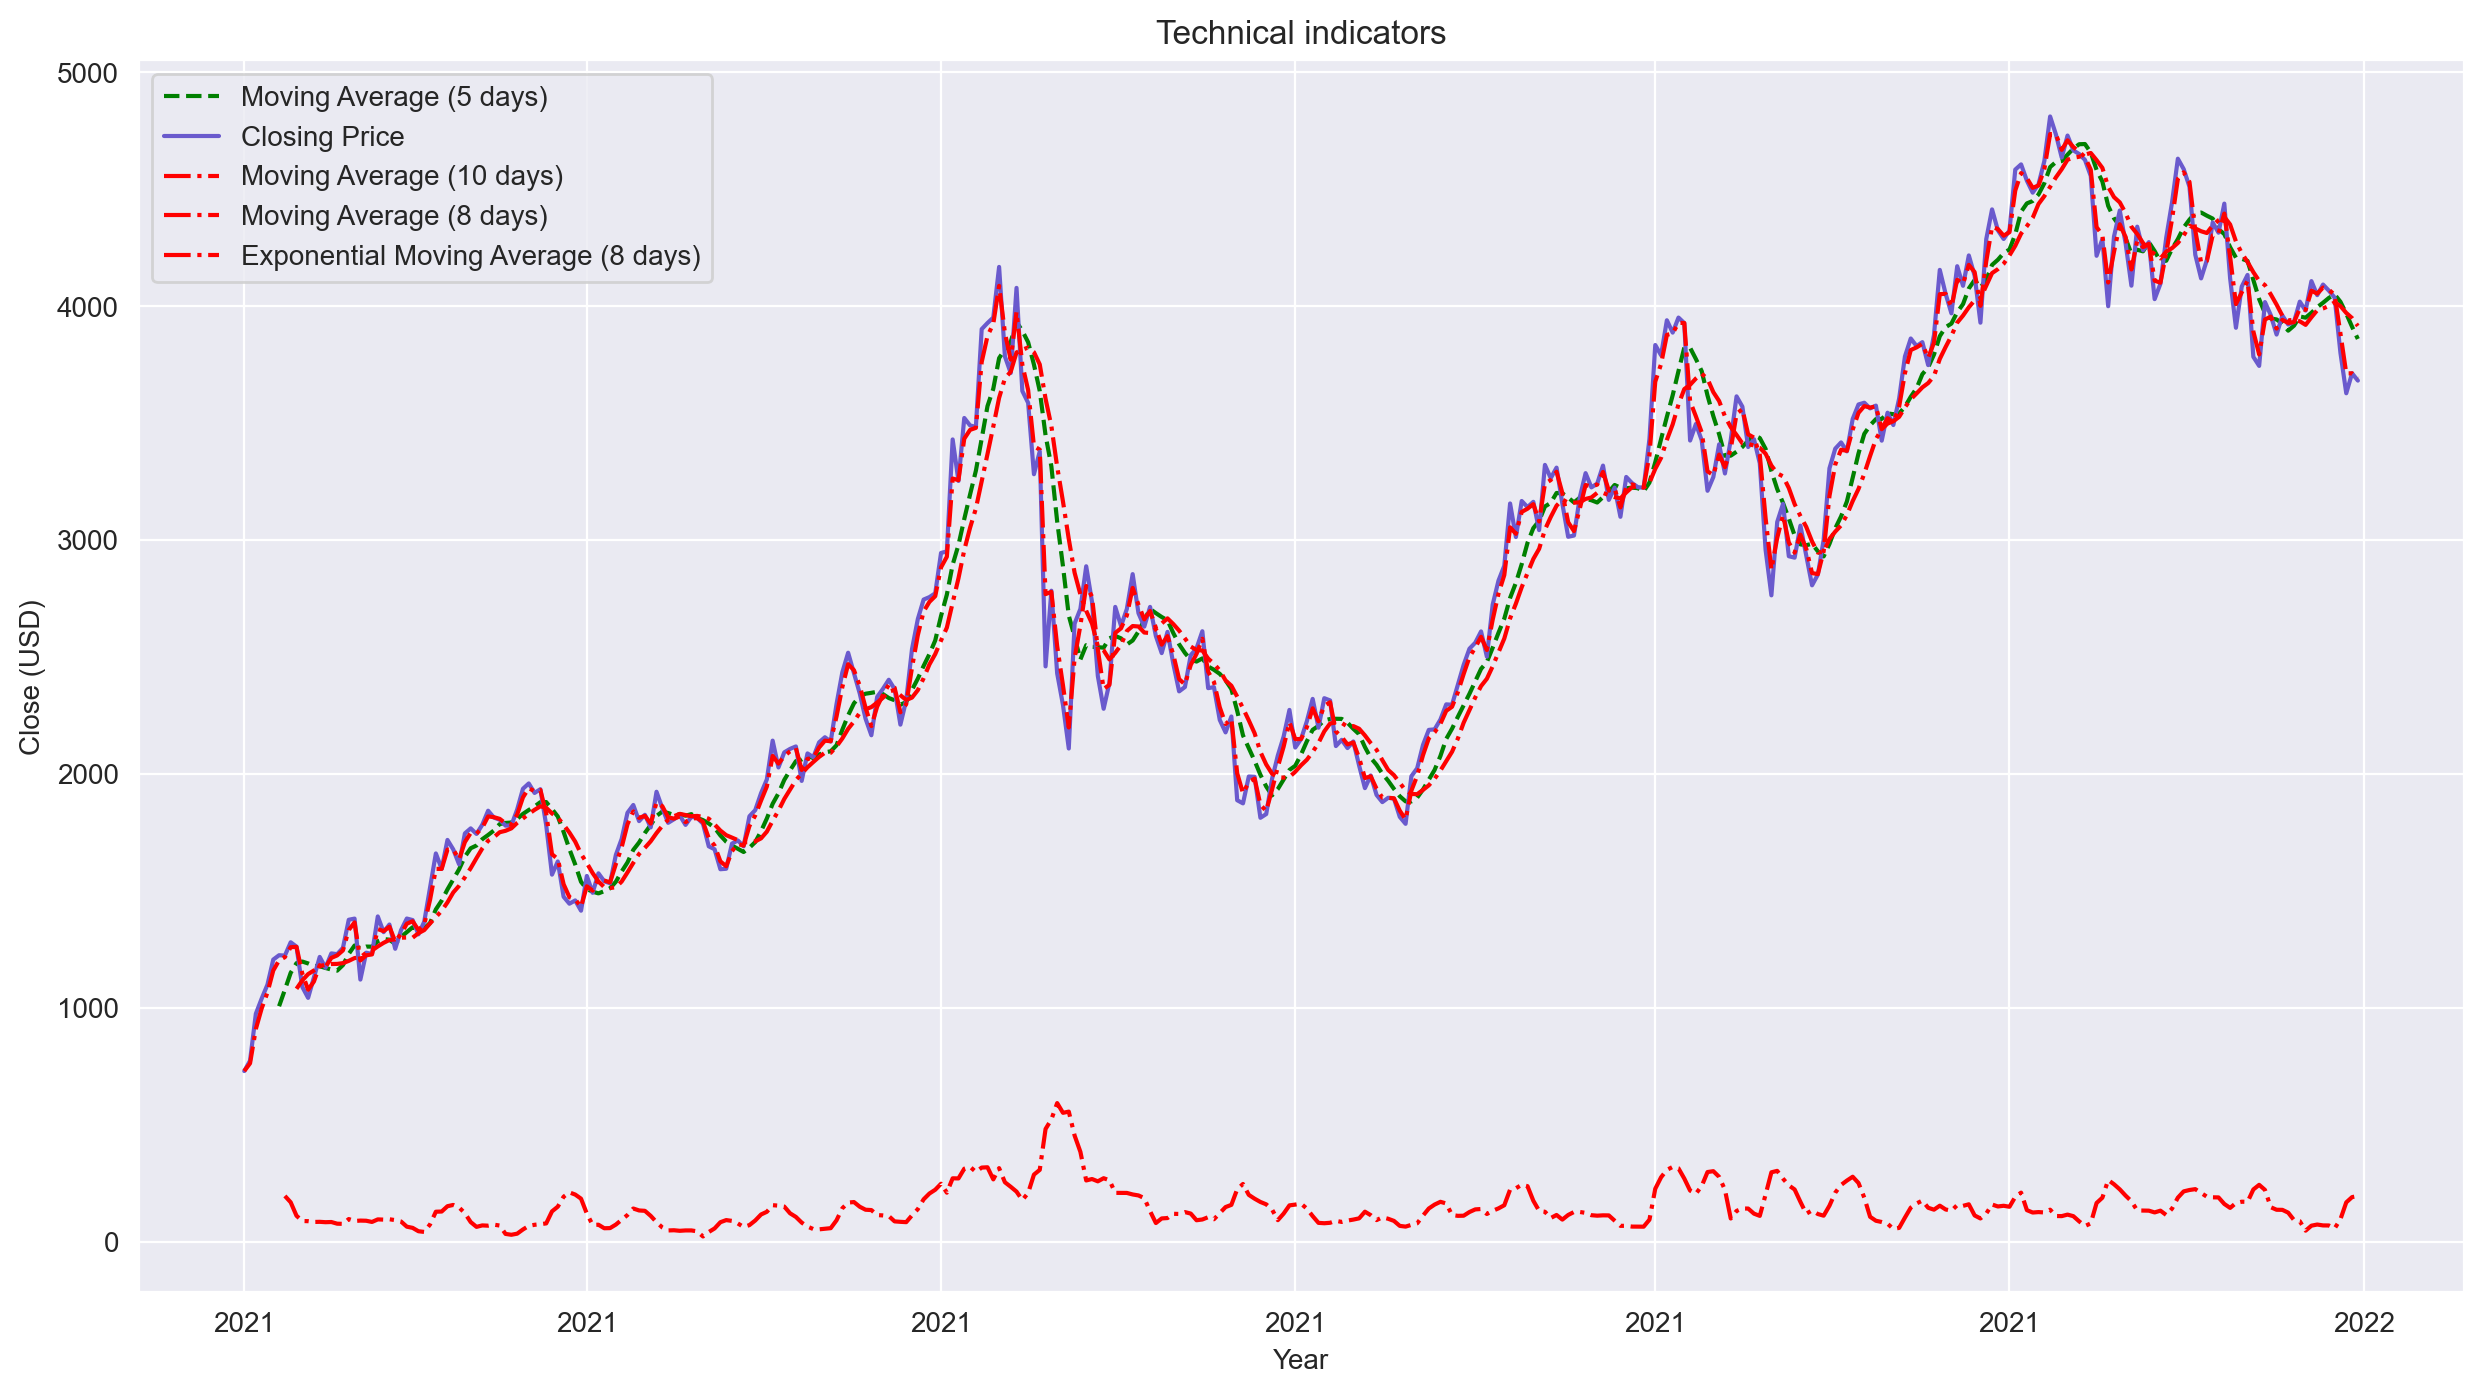

In [1364]:
tech_ind(df5)

<h3>5 days and 10 days dataset copy</h3>

In [1365]:
dataset_5_days = df5.iloc[6:,:].reset_index(drop=True)
dataset_5_days.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-07 00:00:00+00:00,1208.078369,1282.579590,1167.443115,1225.678101,4.046803e+10,1007.634234,NaN,118.907470,NaN,NaN,NaN,1203.904779
1,2021-01-08 00:00:00+00:00,1225.967896,1273.827515,1076.081543,1224.197144,4.433483e+10,1078.181318,NaN,101.722619,196.472853,NaN,NaN,1217.435084
2,2021-01-09 00:00:00+00:00,1223.740479,1303.871826,1182.270386,1281.077271,3.323311e+10,1150.544503,NaN,93.678942,169.191093,NaN,NaN,1259.865364
3,2021-01-10 00:00:00+00:00,1280.871094,1347.926147,1194.715576,1262.246704,4.061694e+10,1191.507220,1082.096075,73.782225,111.858852,1305.813780,858.378371,1261.452951
4,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,1198.637556,1118.073859,36.767167,89.245201,1296.564261,939.583456,1147.247263


In [1366]:
dataset_10_days = df5.iloc[11:,:].reset_index(drop=True)
dataset_10_days.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,1190.555908,1144.963818,26.421413,88.539272,1322.042362,967.885275,1078.038671
1,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,1179.645508,1160.486987,34.872771,85.214707,1330.916402,990.057572,1113.172499
2,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,1178.613351,1178.308984,38.569672,85.764193,1349.837370,1006.780598,1183.359516
3,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,1171.132987,1185.491833,22.663302,84.168607,1353.829048,1017.154619,1175.676235
4,2021-01-16 00:00:00+00:00,1171.443115,1290.053589,1157.623779,1233.537598,3.231924e+10,1164.341605,1188.134375,23.505370,84.965703,1358.065782,1018.202968,1214.250478


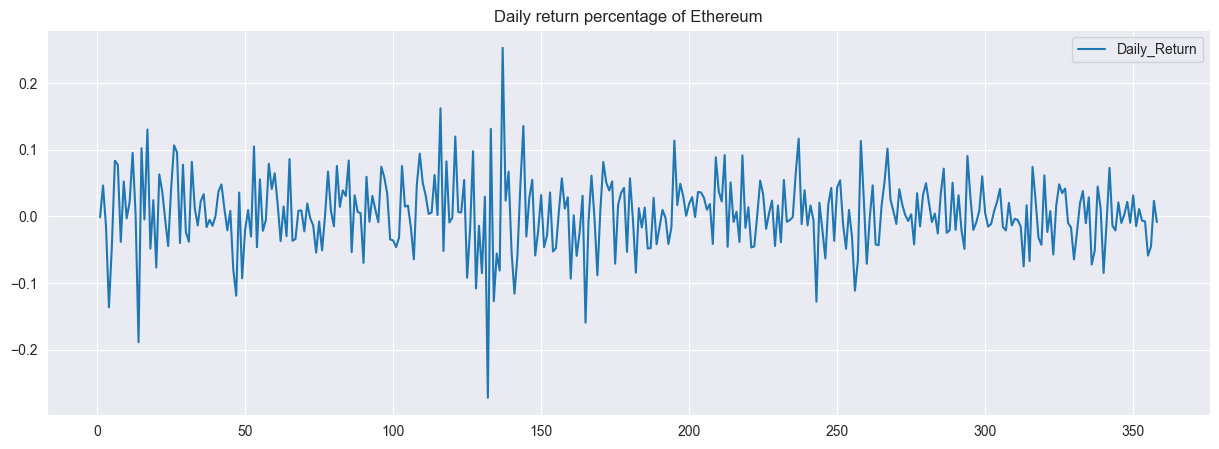

In [1367]:
dataset_5_days['Daily_Return'] = dataset_5_days['Close'].pct_change()

# plot the daily return percentage
dataset_5_days.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Ethereum')
plt.show()

<h2>Final Data Preparation</h2>
<h3>Change values for data training</h3>

(ZACZYNAMY OD TEGO MIEJSCA)

In [1368]:
import numpy as np

# jeśli nie ma trade_sign → utwórz
if 'trade_sign' not in dataset_5_days.columns:
    # wariant 1: znak jednodniowej zmiany ceny Close
    ds = dataset_5_days.copy()
    close = ds['Close'].astype(float)
    trade_sign = np.sign(close.diff()).fillna(0.0)  # -1, 0, 1
    ds['trade_sign'] = trade_sign
    dataset_5_days = ds.dropna().copy()

print(dataset_5_days.columns.tolist())

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MACD', '8SD', 'upper_band', 'lower_band', 'EMA', 'Daily_Return', 'trade_sign']


In [1369]:
dataset_5_days_trade_sign = dataset_5_days[['Open', 'Close', 'High', 'Low', 'trade_sign']]

In [1370]:
# normalize 5 days data
scaler = MinMaxScaler(feature_range=(-1,1)).fit(dataset_5_days_trade_sign)

data_5_days_trade_sign = scaler.transform(dataset_5_days_trade_sign)
print(data_5_days_trade_sign)

[[-0.87407895 -0.8838778  -0.88630991 -0.85774601 -1.        ]
 [-0.88430013 -0.97521087 -0.93224806 -1.         -1.        ]
 [-0.97621782 -1.         -0.99206799 -0.9536837  -1.        ]
 ...
 [ 0.46226968  0.37189456  0.43379344  0.41723742 -1.        ]
 [ 0.37453624  0.41717351  0.40163149  0.40796216  1.        ]
 [ 0.41766068  0.40060566  0.42277875  0.42993093 -1.        ]]


<h2>5 day long sequences</h2>

In [1371]:
seq_len_5_days=6
sequences_5_days_trade_sign=[]
for index in range(len(data_5_days_trade_sign) - seq_len_5_days + 1): 
    sequences_5_days_trade_sign.append(data_5_days_trade_sign[index: index + seq_len_5_days])
sequences_5_days_trade_sign = np.array(sequences_5_days_trade_sign)

sequences_5_days_trade_sign

array([[[-0.87407895, -0.8838778 , -0.88630991, -0.85774601,
         -1.        ],
        [-0.88430013, -0.97521087, -0.93224806, -1.        ,
         -1.        ],
        [-0.97621782, -1.        , -0.99206799, -0.9536837 ,
         -1.        ],
        [-1.        , -0.95366789, -1.        , -0.96328799,
          1.        ],
        [-0.95407188, -0.90711884, -0.94154172, -0.91134563,
          1.        ],
        [-0.90540594, -0.93185893, -0.93816554, -0.91257929,
         -1.        ]],

       [[-0.88430013, -0.97521087, -0.93224806, -1.        ,
         -1.        ],
        [-0.97621782, -1.        , -0.99206799, -0.9536837 ,
         -1.        ],
        [-1.        , -0.95366789, -1.        , -0.96328799,
          1.        ],
        [-0.95407188, -0.90711884, -0.94154172, -0.91134563,
          1.        ],
        [-0.90540594, -0.93185893, -0.93816554, -0.91257929,
         -1.        ],
        [-0.93218749, -0.89911354, -0.91711476, -0.87730344,
          1. 

In [1372]:
valid_set_size_percentage_trade_sign = 10 
test_set_size_percentage_trade_sign = 10 

valid_set_size_trade_sign = int(np.round(valid_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))  
test_set_size_trade_sign  = int(np.round(test_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))
train_set_size_trade_sign = sequences_5_days_trade_sign.shape[0] - (valid_set_size_trade_sign + test_set_size_trade_sign)

x_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,:-1,:]
y_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,-1,:]
    
x_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,:-1,:]
y_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,-1,:]
    
x_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,:-1,:]
y_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,-1,:]

<h2>Building Neural Network and its components with Torch<h2>

In [1373]:
from torch.utils.data import Dataset, DataLoader
import torch

class SequenceDataset(Dataset):
    """
    Gwarantuje spójne kształty:
      x: (N, T-1, F)
      y: (N, F)
    """
    def __init__(self, x_np, y_np):
        x = torch.as_tensor(x_np, dtype=torch.float32)
        y = torch.as_tensor(y_np, dtype=torch.float32)

        # Jeśli ktoś przez pomyłkę poda (N,1,F) albo (N,T,F) -> weź ostatni krok
        if y.ndim == 3:
            y = y[:, -1, :]

        assert x.ndim == 3, f"Expected x.ndim==3, got {x.ndim}"
        assert y.ndim == 2, f"Expected y.ndim==2, got {y.ndim}"
        assert x.shape[0] == y.shape[0], "x and y must have same N"
        assert x.shape[2] == y.shape[1], "feature dim must match (F)"

        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def make_loaders(
    x_train, y_train,
    x_valid, y_valid,
    x_test,  y_test,
    batch_size: int = 32,
    shuffle_train: bool = True,
    num_workers: int = 0,
    pin_memory: bool = False,
):
    train_ds = SequenceDataset(x_train, y_train)
    valid_ds = SequenceDataset(x_valid, y_valid)
    test_ds  = SequenceDataset(x_test,  y_test)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_train,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    return train_dl, valid_dl, test_dl


# --- zbuduj dataloadery z już przygotowanych tablic ---
train_dataloader_5_days_trade_sign, \
valid_dataloader_5_days_trade_sign, \
test_dataloader_5_days_trade_sign = make_loaders(
    x_train_5_days_trade_sign, y_train_5_days_trade_sign,
    x_valid_5_days_trade_sign, y_valid_5_days_trade_sign,
    x_test_5_days_trade_sign,  y_test_5_days_trade_sign,
    batch_size=32, shuffle_train=True, num_workers=0, pin_memory=False
)

# Kontrola kształtów
xb, yb = next(iter(train_dataloader_5_days_trade_sign))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # (B, T-1, F), (B, F)


Batch shapes: (32, 5, 5) (32, 5)


In [1374]:
import torch.nn.functional as F  # opcjonalnie
from torch import nn

class NeuralNetwork(nn.Module):
    """
    Wejście:  x -> (B, T, F)
    Wyjście:  y -> (B, F)   (predykcja ostatniego kroku)
    """
    def __init__(self, num_feature: int, hidden_size: int = 64, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_feature,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, num_feature)

    def forward(self, x):
        # x: (B, T, F)
        output, (hidden, cell) = self.lstm(x)
        last_hidden = hidden[-1]         # (B, hidden_size)
        out = self.head(last_hidden)     # (B, F)
        return out


In [1375]:
model = NeuralNetwork(5)

In [1376]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [1377]:
from torchinfo import summary
summary(model, input_size=(32, 5, 5))  # (batch, seq_len, features)

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [32, 5]                   --
├─LSTM: 1-1                              [32, 5, 64]               18,176
├─Linear: 1-2                            [32, 5]                   325
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.07
Estimated Total Size (MB): 0.16

In [1378]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()

In [1379]:
def train(dataloader, device="cpu"):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)           # (B, F)
        loss = mse(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(n_batches, 1)


In [1380]:
def evaluate(dataloader, device="cpu"):
    model.eval()
    running_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)        # (B, F)
            loss = mse(pred, y)
            running_loss += loss.item()
            n_batches += 1

    return running_loss / max(n_batches, 1)


<h2>Training and Validation comparison plot function</h2>

In [1381]:
def plot_loss(train_losses, valid_losses):
    plt.plot(train_losses, color='black', label='test loss')
    plt.plot(valid_losses, color='blue', label='validation loss')

    plt.title('Loss function comparison')
    plt.xlabel('time')
    plt.ylabel('loss values')
    plt.legend(loc='best')
    plt.show()

<h2>Network training loop</h2>

<h3>This code chunk contains code for best fit model</h3>

In [1382]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

n_epochs = 1300
patience = 50
best_valid_loss = float('inf')
epochs_no_improve = 0

train_losses = []
valid_losses = []

for epoch_instance in range(1, n_epochs + 1):
    train_loss = train(train_dataloader_5_days_trade_sign, device=device)
    valid_loss = evaluate(valid_dataloader_5_days_trade_sign, device=device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    improved = valid_loss < best_valid_loss - 1e-8
    if improved:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'saved_weights.pt')  # zapisuj state_dict
    else:
        epochs_no_improve += 1

    if epoch_instance % 10 == 0 or improved:
        print(f"Epoch {epoch_instance:4d} | Train: {train_loss:.6f} | Val: {valid_loss:.6f}")

    if epochs_no_improve >= patience:
        print(f"Early stop (patience={patience}) @ epoch {epoch_instance}")
        break


Epoch    1 | Train: 0.358174 | Val: 0.641291
Epoch    2 | Train: 0.306957 | Val: 0.601422
Epoch    3 | Train: 0.254542 | Val: 0.515237
Epoch    4 | Train: 0.231425 | Val: 0.412393
Epoch    5 | Train: 0.215371 | Val: 0.330855
Epoch    6 | Train: 0.206156 | Val: 0.267074
Epoch    7 | Train: 0.203865 | Val: 0.234465
Epoch    8 | Train: 0.203538 | Val: 0.226905
Epoch   10 | Train: 0.201953 | Val: 0.222850
Epoch   11 | Train: 0.201603 | Val: 0.215440
Epoch   12 | Train: 0.201521 | Val: 0.210062
Epoch   13 | Train: 0.200544 | Val: 0.207339
Epoch   14 | Train: 0.200952 | Val: 0.205430
Epoch   15 | Train: 0.199976 | Val: 0.204166
Epoch   16 | Train: 0.200076 | Val: 0.202973
Epoch   17 | Train: 0.199756 | Val: 0.200459
Epoch   19 | Train: 0.198932 | Val: 0.196445
Epoch   20 | Train: 0.198810 | Val: 0.195575
Epoch   22 | Train: 0.198303 | Val: 0.193900
Epoch   23 | Train: 0.198482 | Val: 0.192530
Epoch   24 | Train: 0.197606 | Val: 0.191595
Epoch   25 | Train: 0.198721 | Val: 0.190046
Epoch   26

<h2> Visualization of results</h2>

In [1383]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

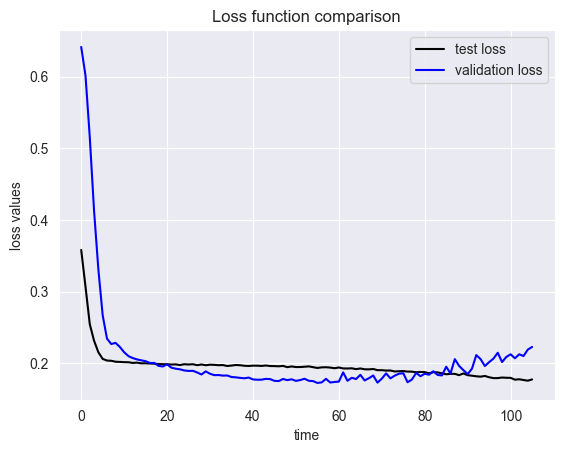

In [1384]:
plot_loss(train_losses=train_losses, valid_losses=valid_losses)

<h2>Loading saved weights data and conducting Predictions</h2>
<h3>Continued part after skipping the hyperparameter tuning</h3>

In [1385]:
# Ładujemy model i przełączamy w eval — UWAGA: ładujemy state_dict, a nie pełny obiekt!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_test = NeuralNetwork(5).to(device)
state = torch.load('saved_weights.pt', map_location=device)
model_test.load_state_dict(state)
model_test.eval()

@torch.no_grad()
def predict_full(model, loader, device="cpu"):
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pb = model(xb)           # (B, F)
        ys.append(yb.cpu())
        ps.append(pb.cpu())
    y = torch.cat(ys, dim=0).numpy()    # (N_test, F)
    p = torch.cat(ps, dim=0).numpy()    # (N_test, F)
    return y, p

y_test_np, y_pred_np = predict_full(model_test, test_dataloader_5_days_trade_sign, device=device)
print("Prediction shapes:", y_test_np.shape, y_pred_np.shape)


Prediction shapes: (35, 5) (35, 5)


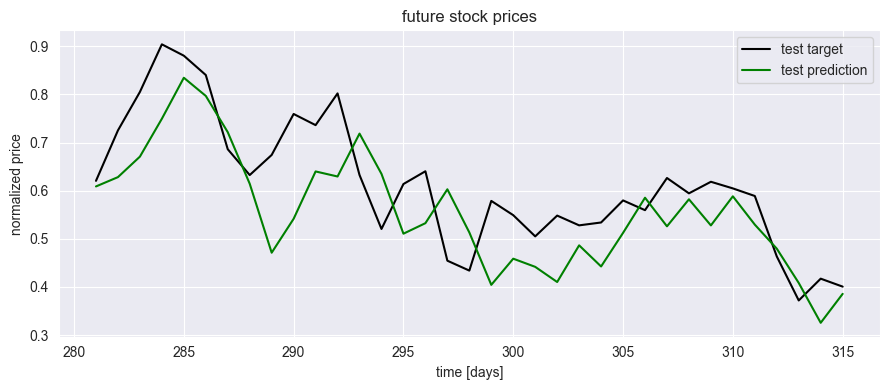

MAE  (Close): 0.08574316650629044
MAPE (Close): 0.14034639298915863


In [1386]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Rysujemy np. 'Close' = idx=1 (Open=0, Close=1, High=2, Low=3, trade_sign=4)
idx = 1
n_train = len(y_train_5_days_trade_sign)
x_axis = np.arange(n_train, n_train + y_test_np.shape[0])

plt.figure(figsize=(9,4))
plt.plot(x_axis, y_test_np[:, idx],  color='black', label='test target')
plt.plot(x_axis, y_pred_np[:, idx],  color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("MAE  (Close):", mean_absolute_error(y_test_np[:, idx], y_pred_np[:, idx]))
print("MAPE (Close):", mean_absolute_percentage_error(y_test_np[:, idx], y_pred_np[:, idx]))


## New after Jarek sugestions

In [1387]:
# === KONFIG ===
HORIZONS = [1, 3, 5, 10]     # w krokach (dni / interwały jak w Twoich danych)
INPUT_LEN = 32               # długość okna wejściowego (możesz zwiększyć)
TEST_SIZE = 0.15
VALID_SIZE = 0.15
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 500
PATIENCE = 40
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MH_FEATURES = ['Open', 'Close', 'High', 'Low', 'trade_sign']

# Seed dla powtarzalności
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [1388]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Bierzemy dane z istniejącej ramki; jeśli nie masz 'dataset_5_days', użyj tej, którą masz po "New".
if 'dataset_5_days' in globals():
    df_src = dataset_5_days.copy()
else:
    # Jeśli w notatniku masz inną ramkę z tymi samymi kolumnami, podmień tutaj:
    df_src = dataset_5_days_trade_sign.copy()

# Upewnij się, że kolumny są
missing = [c for c in MH_FEATURES if c not in df_src.columns]
if missing:
    raise ValueError(f"Brakuje kolumn w danych: {missing}. Podmień MH_FEATURES lub źródło danych.")

# Skalowanie na osobnym skalerze, żeby nie popsuć wcześniejszych rzeczy
scaler_mh = MinMaxScaler(feature_range=(-1, 1))
X_full_np = scaler_mh.fit_transform(df_src[MH_FEATURES].values)   # shape: (N_all, F)

def build_multi_horizon_sequences(x_full, input_len, horizons):
    """
    Zwraca:
      X: (N, input_len, F)
      Y: (N, H, F)  — gdzie H = len(horizons)
    """
    F = x_full.shape[1]
    H = len(horizons)
    max_h = max(horizons)
    seqs_X, seqs_Y = [], []

    for t in range(input_len, len(x_full) - max_h):
        x_win = x_full[t - input_len:t]                       # (input_len, F)
        y_targets = []
        for h in horizons:
            y_targets.append(x_full[t + h, :])               # (F,)
        y_targets = np.stack(y_targets, axis=0)               # (H, F)
        seqs_X.append(x_win)
        seqs_Y.append(y_targets)

    X = np.stack(seqs_X, axis=0)   # (N, input_len, F)
    Y = np.stack(seqs_Y, axis=0)   # (N, H, F)
    return X, Y

X_mh, Y_mh = build_multi_horizon_sequences(X_full_np, INPUT_LEN, HORIZONS)

N = X_mh.shape[0]
n_test  = int(round(N * TEST_SIZE))
n_valid = int(round(N * VALID_SIZE))
n_train = N - n_test - n_valid
assert n_train > 0 and n_valid > 0 and n_test > 0, "Za mało danych na taki podział."

X_train_mh = X_mh[:n_train]
Y_train_mh = Y_mh[:n_train]
X_valid_mh = X_mh[n_train:n_train+n_valid]
Y_valid_mh = Y_mh[n_train:n_train+n_valid]
X_test_mh  = X_mh[n_train+n_valid:]
Y_test_mh  = Y_mh[n_train+n_valid:]

X_train_mh.shape, Y_train_mh.shape


((220, 32, 5), (220, 4, 5))

[HCR    1] train=0.060162 | valid=0.049142 | best=0.049142
[HCR    2] train=0.051306 | valid=0.048904 | best=0.048904
[HCR    3] train=0.043872 | valid=0.048652 | best=0.048652
[HCR    4] train=0.037725 | valid=0.048378 | best=0.048378
[HCR    5] train=0.032675 | valid=0.048062 | best=0.048062
[HCR    6] train=0.028555 | valid=0.047711 | best=0.047711
[HCR    7] train=0.025197 | valid=0.047341 | best=0.047341
[HCR    8] train=0.022443 | valid=0.046964 | best=0.046964
[HCR    9] train=0.020157 | valid=0.046593 | best=0.046593
[HCR   10] train=0.018235 | valid=0.046235 | best=0.046235
[HCR   11] train=0.016598 | valid=0.045894 | best=0.045894
[HCR   12] train=0.015187 | valid=0.045574 | best=0.045574
[HCR   13] train=0.013958 | valid=0.045274 | best=0.045274
[HCR   14] train=0.012878 | valid=0.044993 | best=0.044993
[HCR   15] train=0.011922 | valid=0.044727 | best=0.044727
[HCR   16] train=0.011071 | valid=0.044475 | best=0.044475
[HCR   17] train=0.010308 | valid=0.044233 | best=0.0442

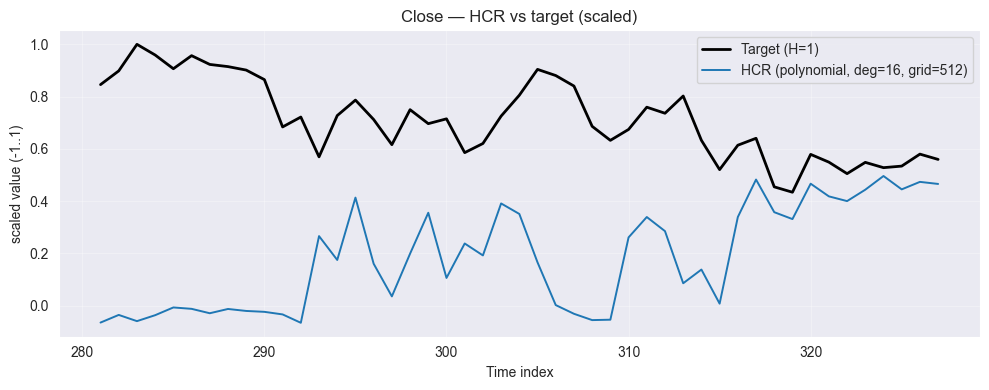

In [ ]:

# # HCR test
import torch, torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import inspect

from hcr_nn.models import HCRCond2D, build_hcr_cond2d
from hcr_nn.basis import select_basis

# --- Parametry HCR ---
FEATURE_NAME = "Close"
BASIS_NAME   = "polynomial"
DEGREE       = 16
GRID_SIZE    = 512
LR_HCR       = 1e-2
EPOCHS_HCR   = 800
PATIENCE_HCR = 400
EPS_DENS     = 1e-8

assert FEATURE_NAME in MH_FEATURES, f"{FEATURE_NAME=} nie ma w MH_FEATURES={MH_FEATURES}"
f_idx   = MH_FEATURES.index(FEATURE_NAME)
h_idx   = 0  # H=1 => indeks 0


def to_u(x_scaled):  # [-1,1] -> [0,1]
    return (x_scaled + 1.0) / 2.0

u2_all = X_mh[:, -1, f_idx]
u1_all = Y_mh[:, h_idx, f_idx]   # target H=1
u2_all_u = to_u(u2_all)
u1_all_u = to_u(u1_all)


N = u2_all_u.shape[0]
n_test  = int(round(N * TEST_SIZE))
n_valid = int(round(N * VALID_SIZE))
n_train = N - n_test - n_valid

u2_tr, u2_va, u2_te = np.split(u2_all_u, [n_train, n_train+n_valid])
u1_tr, u1_va, u1_te = np.split(u1_all_u, [n_train, n_train+n_valid])


class HCRDataset(torch.utils.data.Dataset):
    def __init__(self, u2, u1):
        self.x = torch.tensor(np.stack([u1, u2], axis=1), dtype=torch.float32)
        self.y = torch.tensor(u1, dtype=torch.float32)
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, i): return self.x[i], self.y[i]

dl_tr = torch.utils.data.DataLoader(HCRDataset(u2_tr, u1_tr), batch_size=512, shuffle=True)
dl_va = torch.utils.data.DataLoader(HCRDataset(u2_va, u1_va), batch_size=1024, shuffle=False)
dl_te = torch.utils.data.DataLoader(HCRDataset(u2_te, u1_te), batch_size=1024, shuffle=False)

hcr = build_hcr_cond2d(
    degree=DEGREE,
    basis=BASIS_NAME,
    grid_size=GRID_SIZE,
    coeff_init="xavier",
    dtype=torch.float32,
    device=DEVICE,
).to(DEVICE)

opt = torch.optim.Adam(hcr.parameters(), lr=LR_HCR, weight_decay=1e-3)
loss_fn = nn.MSELoss()

best_va = float("inf")
bad = 0
hist_hcr = {"train": [], "valid": []}

for ep in range(1, EPOCHS_HCR+1):
    # train
    hcr.train()
    bl = []
    for xb, yb in dl_tr:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        pred = hcr(xb)         # (B,) — E[u1|u2] w [0,1]
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        bl.append(loss.item())
    tr = float(np.mean(bl))

    # valid
    hcr.eval()
    with torch.no_grad():
        vl = []
        for xb, yb in dl_va:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            vl.append(loss_fn(hcr(xb), yb).item())
        va = float(np.mean(vl))

    hist_hcr["train"].append(tr); hist_hcr["valid"].append(va)
    improved = va < best_va - 1e-9
    if improved:
        best_va = va; bad = 0
        best_state = {k: v.detach().cpu().clone() for k,v in hcr.state_dict().items()}
    else:
        bad += 1

    if ep % 20 == 0 or improved:
        print(f"[HCR {ep:4d}] train={tr:.6f} | valid={va:.6f} | best={best_va:.6f}")
    if bad >= PATIENCE_HCR:
        print(f"HCR Early stop @ {ep} (patience={PATIENCE_HCR})")
        break

if 'best_state' in locals():
    hcr.load_state_dict(best_state)

@torch.no_grad()
def predict_hcr(loader):
    hcr.eval()
    Ps, Ys = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        Ps.append(hcr(xb).cpu())
        Ys.append(yb.cpu())
    p = torch.cat(Ps).numpy()
    y = torch.cat(Ys).numpy()

    return 2.0*p - 1.0, 2.0*y - 1.0

u1_pred_scaled, u1_true_scaled = predict_hcr(dl_te)

from sklearn.metrics import mean_absolute_error
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred)/denom)))

mae_hcr  = mean_absolute_error(u1_true_scaled, u1_pred_scaled)
mape_hcr = mape_safe(u1_true_scaled, u1_pred_scaled)
print(f"[HCR] {FEATURE_NAME} | MAE={mae_hcr:.6f} | MAPE={mape_hcr:.6f}")

# --- Wykres HCR vs target  ---
N_test_len   = u1_true_scaled.shape[0]
n_train_old  = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
x_axis       = np.arange(n_train_old, n_train_old + N_test_len)

plt.figure(figsize=(10,4))
plt.plot(x_axis, u1_true_scaled,  label='Target (H=1)', lw=2.0, color='black')
plt.plot(x_axis, u1_pred_scaled,  label=f'HCR ({BASIS_NAME}, deg={DEGREE}, grid={GRID_SIZE})', lw=1.4)
plt.title(f'{FEATURE_NAME} — HCR vs target (scaled)')
plt.xlabel('Time index'); plt.ylabel('scaled value (-1..1)')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
import optuna
from sklearn.metrics import mean_absolute_error


def objective():
    """
    objective function for Optuna 
    Hyperparameter Tuning
    """ 
    
    hcr = build_hcr_cond2d(
        degree=DEGREE,
        basis=BASIS_NAME,
        grid_size=GRID_SIZE,
        coeff_init="xavier",
        dtype=torch.float32,
        device=DEVICE,
    ).to(DEVICE)

    opt = torch.optim.Adam(hcr.parameters(), lr=LR_HCR, weight_decay=1e-3)
    loss_fn = nn.MSELoss()

    best_va = float("inf")
    bad = 0
    hist_hcr = {"train": [], "valid": []}

    for ep in range(1, EPOCHS_HCR+1):
        # train
        hcr.train()
        bl = []
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = hcr(xb)         # (B,) — E[u1|u2] w [0,1]
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            bl.append(loss.item())
        tr = float(np.mean(bl))

        # valid
        hcr.eval()
        with torch.no_grad():
            vl = []
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                vl.append(loss_fn(hcr(xb), yb).item())
            va = float(np.mean(vl))

        hist_hcr["train"].append(tr); hist_hcr["valid"].append(va)
        improved = va < best_va - 1e-9
        if improved:
            best_va = va; bad = 0
            best_state = {k: v.detach().cpu().clone() for k,v in hcr.state_dict().items()}
        else:
            bad += 1

        if ep % 20 == 0 or improved:
            print(f"[HCR {ep:4d}] train={tr:.6f} | valid={va:.6f} | best={best_va:.6f}")
        if bad >= PATIENCE_HCR:
            print(f"HCR Early stop @ {ep} (patience={PATIENCE_HCR})")
            break

    if 'best_state' in locals():
        hcr.load_state_dict(best_state)

    @torch.no_grad()
    def predict_hcr(loader):
        hcr.eval()
        Ps, Ys = [], []
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            Ps.append(hcr(xb).cpu())
            Ys.append(yb.cpu())
        p = torch.cat(Ps).numpy()
        y = torch.cat(Ys).numpy()

        return 2.0*p - 1.0, 2.0*y - 1.0

    u1_pred_scaled, u1_true_scaled = predict_hcr(dl_te)

    def mape_safe(y_true, y_pred, eps=1e-8):
        y_true = np.asarray(y_true).ravel()
        y_pred = np.asarray(y_pred).ravel()
        denom = np.maximum(np.abs(y_true), eps)
        return float(np.mean(np.abs((y_true - y_pred)/denom)))

    mae_hcr  = mean_absolute_error(u1_true_scaled, u1_pred_scaled)
    mape_hcr = mape_safe(u1_true_scaled, u1_pred_scaled)
    print(f"[HCR] {FEATURE_NAME} | MAE={mae_hcr:.6f} | MAPE={mape_hcr:.6f}")

    return (mae_hcr, mape_hcr)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best Hyperparameters:", study.best_params)

In [1390]:
from torch.utils.data import Dataset, DataLoader
import torch

class MultiHorizonDataset(Dataset):
    """
    x: (N, T, F)
    y: (N, H, F)
    """
    def __init__(self, x_np, y_np):
        x = torch.as_tensor(x_np, dtype=torch.float32)
        y = torch.as_tensor(y_np, dtype=torch.float32)
        assert x.ndim == 3 and y.ndim == 3, "Oczekuję x:(N,T,F), y:(N,H,F)"
        assert x.shape[0] == y.shape[0] and x.shape[2] == y.shape[2], "N i F muszą się zgadzać"
        self.x, self.y = x, y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def make_loaders_mh(Xtr, Ytr, Xva, Yva, Xte, Yte, bs=BATCH_SIZE, num_workers=0, pin_memory=False):
    tr_ds = MultiHorizonDataset(Xtr, Ytr)
    va_ds = MultiHorizonDataset(Xva, Yva)
    te_ds = MultiHorizonDataset(Xte, Yte)
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True,  num_workers=num_workers, pin_memory=pin_memory)
    va_dl = DataLoader(va_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    te_dl = DataLoader(te_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    return tr_dl, va_dl, te_dl

train_dl_mh, valid_dl_mh, test_dl_mh = make_loaders_mh(X_train_mh, Y_train_mh, X_valid_mh, Y_valid_mh, X_test_mh, Y_test_mh)

xb, yb = next(iter(train_dl_mh))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # (B, T, F), (B, H, F)


Batch shapes: (64, 32, 5) (64, 4, 5)


In [1391]:
import torch.nn as nn
import torch

F = len(MH_FEATURES)
H = len(HORIZONS)

class LSTM_MH(nn.Module):
    """
    LSTM -> linear -> (B, H, F)
    """
    def __init__(self, in_features=F, hidden_size=128, num_layers=1, dropout=0.0, horizons=H):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, horizons * in_features)
        self.horizons = horizons
        self.in_features = in_features

    def forward(self, x):  # x: (B, T, F)
        _, (h, _) = self.lstm(x)         # h: (num_layers, B, hidden)
        h_last = h[-1]                    # (B, hidden)
        out = self.head(h_last)           # (B, H*F)
        out = out.view(-1, self.horizons, self.in_features)  # (B, H, F)
        return out


class AdaptiveStudent(nn.Module):
    """
    'Adaptacyjna EMA' z parametrami ucznia wyznaczanymi z okna wejściowego.
    - Uczy się `alpha` w (0,1) per FEATURE (i opcjonalnie zależne od kontekstu).
    - Generuje H prognoz rekurencyjnie: y_{t+h} = alpha * y_{t+h-1} + (1-alpha) * x_{t}
    gdzie x_t to wektor na końcu okna wejściowego (ostatni punkt).
    """
    def __init__(self, in_features=F, horizons=H, context_hidden=64):
        super().__init__()
        self.in_features = in_features
        self.horizons = horizons
        # mała sieć, która z ostatniego okna robi wektor alf
        self.phi = nn.Sequential(
            nn.Flatten(),                       # (B, T*F)
            nn.Linear(INPUT_LEN*in_features, context_hidden),
            nn.ReLU(),
            nn.Linear(context_hidden, in_features),
            nn.Sigmoid()                        # alpha w (0,1)
        )
        # waga miksu: czy używać bardziej "ostatniej obserwacji" czy "poprzedniej prognozy"
        # Nie jest konieczna, ale pomaga stabilizować.
        self.mix_gate = nn.Sequential(
            nn.Flatten(),
            nn.Linear(INPUT_LEN*in_features, in_features),
            nn.Sigmoid()
        )

    def forward(self, x):  # x: (B, T, F)
        B = x.size(0)
        last = x[:, -1, :]                   # (B, F) ostatni punkt z okna
        alpha = self.phi(x)                  # (B, F) adaptacyjne alfy
        gate  = self.mix_gate(x)             # (B, F) bramka miksująca

        preds = []
        y_prev = last
        for _ in range(self.horizons):
            # adaptacyjna ema: y_next = alpha * y_prev + (1-alpha) * last
            y_next = alpha * y_prev + (1 - alpha) * last
            # lekki mix z wejściem (można pominąć)
            y_next = gate * y_next + (1 - gate) * last
            preds.append(y_next)
            y_prev = y_next.detach()  # odpięcie BPTT w głąb horyzontu (stabilniej); usuń .detach() jeśli chcesz pełny BPTT
        y = torch.stack(preds, dim=1)         # (B, H, F)
        return y


In [1392]:
def mse_mh(pred, target):
    # pred, target: (B, H, F)
    return ((pred - target)**2).mean()

@torch.no_grad()
def evaluate_mh(model, loader):
    model.eval()
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pb = model(xb)
        losses.append(mse_mh(pb, yb).item())
    return float(np.mean(losses))

def train_mh(model, train_loader, valid_loader, epochs=EPOCHS, lr=LR, patience=PATIENCE, verbose_every=10, save_path=None):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float('inf')
    bad = 0
    history = {'train': [], 'valid': []}

    model.to(DEVICE)

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pb = model(xb)
            loss = mse_mh(pb, yb)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        tr = float(np.mean(losses))
        va = evaluate_mh(model, valid_loader)
        history['train'].append(tr); history['valid'].append(va)

        improved = va < best_val - 1e-9
        if improved:
            best_val = va
            bad = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            bad += 1

        if ep % verbose_every == 0 or improved:
            print(f"[{ep:4d}] train={tr:.6f} | valid={va:.6f} | best={best_val:.6f}")

        if bad >= patience:
            print(f"Early stop (patience={patience}) @ epoch {ep}")
            break

    return history, best_val


In [1393]:
lstm_mh = LSTM_MH(in_features=F, hidden_size=128, num_layers=1, dropout=0.0, horizons=H).to(DEVICE)
student  = AdaptiveStudent(in_features=F, horizons=H, context_hidden=64).to(DEVICE)

hist_student, best_student = train_mh(
    student, train_dl_mh, valid_dl_mh,
    epochs=EPOCHS, lr=LR, patience=PATIENCE,
    verbose_every=10, save_path="student_mh.pt"
)

hist_lstm, best_lstm = train_mh(
    lstm_mh, train_dl_mh, valid_dl_mh,
    epochs=EPOCHS, lr=LR, patience=PATIENCE,
    verbose_every=10, save_path="lstm_mh.pt"
)

print("Best valid: student:", best_student, " | lstm:", best_lstm)


[   1] train=0.423878 | valid=0.413770 | best=0.413770
[  10] train=0.413399 | valid=0.413770 | best=0.413770
[  20] train=0.425674 | valid=0.413770 | best=0.413770
[  30] train=0.420446 | valid=0.413770 | best=0.413770
[  40] train=0.426382 | valid=0.413770 | best=0.413770
Early stop (patience=40) @ epoch 41
[   1] train=0.339971 | valid=0.450124 | best=0.450124
[   5] train=0.256488 | valid=0.439260 | best=0.439260
[   6] train=0.246277 | valid=0.410784 | best=0.410784
[   7] train=0.241025 | valid=0.382802 | best=0.382802
[   8] train=0.233227 | valid=0.358347 | best=0.358347
[   9] train=0.228939 | valid=0.338173 | best=0.338173
[  10] train=0.228560 | valid=0.316067 | best=0.316067
[  11] train=0.225598 | valid=0.303277 | best=0.303277
[  12] train=0.226002 | valid=0.294429 | best=0.294429
[  13] train=0.223521 | valid=0.286317 | best=0.286317
[  14] train=0.224074 | valid=0.283644 | best=0.283644
[  16] train=0.223794 | valid=0.280925 | best=0.280925
[  20] train=0.221902 | valid

In [1394]:
import numpy as np

def ema_forecast_batch(last_window, alpha, horizons=HORIZONS):
    """
    last_window: (B, T, F)
    alpha: float w (0,1)
    Zwraca: (B, H, F)
    """
    last = last_window[:, -1, :]        # (B, F)
    y_prev = last
    preds = []
    for _ in horizons:
        y_next = alpha * y_prev + (1 - alpha) * last
        preds.append(y_next)
        y_prev = y_next
    return torch.stack(preds, dim=1)

@torch.no_grad()
def evaluate_ema(loader, alpha=0.8):
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pb = ema_forecast_batch(xb, alpha, HORIZONS)
        losses.append(mse_mh(pb, yb).item())
    return float(np.mean(losses))

ema_val_loss = evaluate_ema(valid_dl_mh, alpha=0.8)
ema_test_loss = evaluate_ema(test_dl_mh, alpha=0.8)
print("EMA baseline | valid:", ema_val_loss, "| test:", ema_test_loss)


EMA baseline | valid: 0.41376975178718567 | test: 0.46434685587882996


In [1395]:
@torch.no_grad()
def predict_mh(model, loader):
    model.eval()
    Ys, Ps = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        pb = model(xb)              # (B, H, F)
        Ps.append(pb.cpu())
        Ys.append(yb.cpu())
    Y = torch.cat(Ys, dim=0).numpy()
    P = torch.cat(Ps, dim=0).numpy()
    return Y, P

# Załaduj najlepsze wagi i licz metryki
lstm_mh.load_state_dict(torch.load("lstm_mh.pt", map_location=DEVICE))
student.load_state_dict(torch.load("student_mh.pt", map_location=DEVICE))

Y_test_np = Y_test_mh
Y_stud_np = predict_mh(student, test_dl_mh)[1]
Y_lstm_np = predict_mh(lstm_mh, test_dl_mh)[1]

# EMA
@torch.no_grad()
def predict_ema(loader, alpha=0.8):
    Ps = []
    for xb, _ in loader:
        xb = xb.to(DEVICE)
        pb = ema_forecast_batch(xb, alpha, HORIZONS)
        Ps.append(pb.cpu())
    P = torch.cat(Ps, dim=0).numpy()
    return P

Y_ema_np = predict_ema(test_dl_mh, alpha=0.8)

def mse_per_horizon(pred, target):   # (N, H, F)
    return ((pred - target)**2).mean(axis=(0,2))  # (H,) średnia po N i F

def mae_per_horizon(pred, target):
    return (np.abs(pred - target)).mean(axis=(0,2))

print("MSE per H (student):", mse_per_horizon(Y_stud_np, Y_test_np))
print("MSE per H (lstm)   :", mse_per_horizon(Y_lstm_np, Y_test_np))
print("MSE per H (ema)    :", mse_per_horizon(Y_ema_np,  Y_test_np))


MSE per H (student): [0.47137255 0.5267266  0.39060586 0.46868245]
MSE per H (lstm)   : [0.26097712 0.27418099 0.27830516 0.31159242]
MSE per H (ema)    : [0.47137255 0.5267266  0.39060587 0.46868245]


RMSE(mean) student: 0.11701599839831012
RMSE(mean) lstm   : 0.35373896965551216
RMSE(mean) ema    : 0.11701600382635365


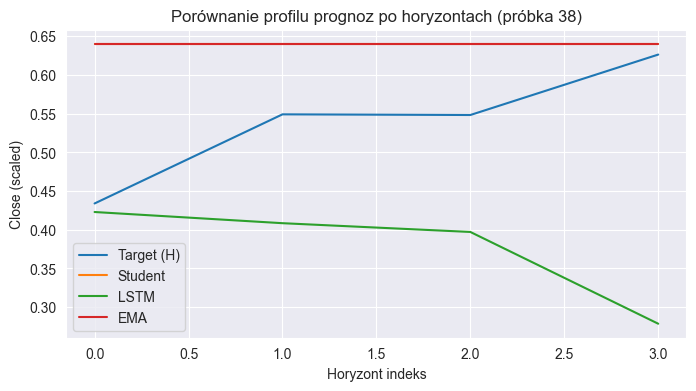

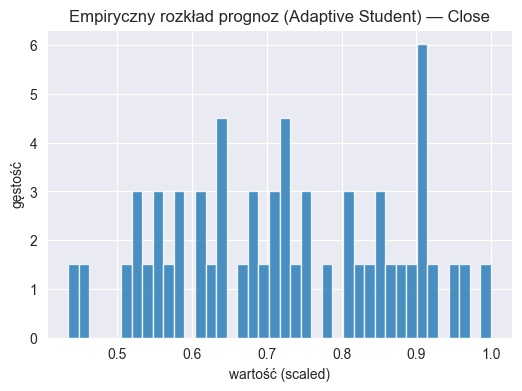

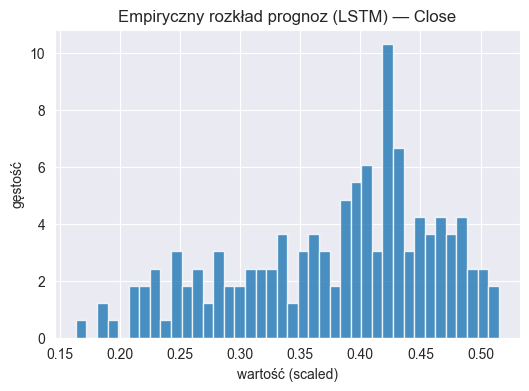

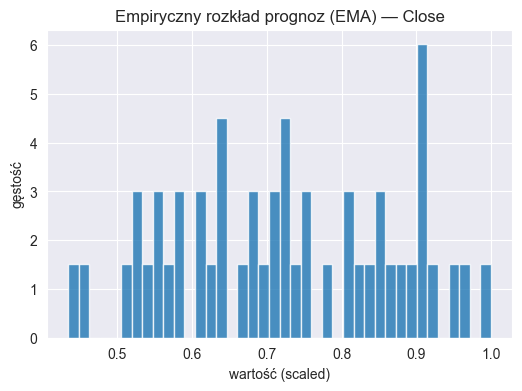

In [1396]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

FEATURE_TO_PLOT = 'Close'
f_idx = MH_FEATURES.index(FEATURE_TO_PLOT)

def dist_stats(pred_mh, target_mh, f_idx):
    """
    pred_mh: (N, H, F), target_mh: (N, H, F)
    Zwraca ramkę: średnie z H, std po H, oraz kilka kwantyli po H (po N uśredniamy)
    """
    # statystyki liczymy po horyzontach (oś=1) i po N uśredniamy
    mean_pred = pred_mh[:,:,f_idx].mean(axis=1)            # (N,)
    std_pred  = pred_mh[:,:,f_idx].std(axis=1)             # (N,)
    q10 = np.quantile(pred_mh[:,:,f_idx], 0.10, axis=1)    # (N,)
    q50 = np.quantile(pred_mh[:,:,f_idx], 0.50, axis=1)
    q90 = np.quantile(pred_mh[:,:,f_idx], 0.90, axis=1)
    # target „następny” możemy wziąć np. h=1 (pierwszy horyzont) — to typowa referencja
    tgt = target_mh[:,0,f_idx]                              # (N,)
    df = pd.DataFrame({
        "target_h1": tgt,
        "pred_mean": mean_pred,
        "pred_std": std_pred,
        "q10": q10,
        "q50": q50,
        "q90": q90
    })
    return df

df_student = dist_stats(Y_stud_np, Y_test_np, f_idx)
df_lstm    = dist_stats(Y_lstm_np,  Y_test_np, f_idx)
df_ema     = dist_stats(Y_ema_np,   Y_test_np, f_idx)

def rmse(a, b): return float(np.sqrt(np.mean((a - b)**2)))
print("RMSE(mean) student:", rmse(df_student['pred_mean'].values, df_student['target_h1'].values))
print("RMSE(mean) lstm   :", rmse(df_lstm['pred_mean'].values,    df_lstm['target_h1'].values))
print("RMSE(mean) ema    :", rmse(df_ema['pred_mean'].values,     df_ema['target_h1'].values))

# Wykres: porównanie „próbki rozkładu” dla jednego przykładu z testu
idx = np.random.randint(0, Y_test_np.shape[0])  # wybierz losową próbkę
x_axis = np.arange(len(HORIZONS))

plt.figure(figsize=(8,4))
plt.plot(x_axis, Y_test_np[idx,:,f_idx], label="Target (H)")
plt.plot(x_axis, Y_stud_np[idx,:,f_idx], label="Student")
plt.plot(x_axis, Y_lstm_np[idx,:,f_idx], label="LSTM")
plt.plot(x_axis, Y_ema_np[idx,:,f_idx],  label="EMA")
plt.xlabel("Horyzont indeks")
plt.ylabel(f"{FEATURE_TO_PLOT} (scaled)")
plt.title(f"Porównanie profilu prognoz po horyzontach (próbka {idx})")
plt.legend()
plt.show()

# Wykres: „rozkład” (histogram) KILKU próbek po H dla danego modelu
def plot_empirical_distribution(P, label):
    vals = P[:, :, f_idx].reshape(-1)    # zbierz wszystkie horyzonty i próbki
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=40, alpha=0.8, density=True)
    plt.title(f"Empiryczny rozkład prognoz ({label}) — {FEATURE_TO_PLOT}")
    plt.xlabel("wartość (scaled)"); plt.ylabel("gęstość")
    plt.show()

plot_empirical_distribution(Y_stud_np, "Adaptive Student")
plot_empirical_distribution(Y_lstm_np, "LSTM")
plot_empirical_distribution(Y_ema_np,  "EMA")


In [1397]:
def mse_per_hf(pred, target):  # (N,H,F)
    # MSE osobno dla par (h, f)
    return ((pred - target)**2).mean(axis=0)  # (H, F)

mse_student_hf = mse_per_hf(Y_stud_np, Y_test_np)
mse_lstm_hf    = mse_per_hf(Y_lstm_np,  Y_test_np)
mse_ema_hf     = mse_per_hf(Y_ema_np,   Y_test_np)

df_mse_student = pd.DataFrame(mse_student_hf, columns=MH_FEATURES, index=[f"H{h}" for h in HORIZONS])
df_mse_lstm    = pd.DataFrame(mse_lstm_hf,    columns=MH_FEATURES, index=[f"H{h}" for h in HORIZONS])
df_mse_ema     = pd.DataFrame(mse_ema_hf,     columns=MH_FEATURES, index=[f"H{h}" for h in HORIZONS])

print("MSE per (H,F) — Student")
display(df_mse_student.style.format("{:.6f}"))

print("MSE per (H,F) — LSTM")
display(df_mse_lstm.style.format("{:.6f}"))

print("MSE per (H,F) — EMA")
display(df_mse_ema.style.format("{:.6f}"))


MSE per (H,F) — Student


,Open,Close,High,Low,trade_sign
H1,0.014173,0.013693,0.013286,0.017839,2.297872
H3,0.018009,0.018534,0.018186,0.025713,2.553191
H5,0.018869,0.020389,0.018510,0.022920,1.872340
H10,0.030999,0.033173,0.032423,0.034052,2.212766


MSE per (H,F) — LSTM


,Open,Close,High,Low,trade_sign
H1,0.061627,0.090077,0.068171,0.093412,0.991599
H3,0.088152,0.094592,0.073776,0.131259,0.983127
H5,0.105779,0.096457,0.078434,0.125138,0.985718
H10,0.136990,0.152888,0.121408,0.143666,1.003010


MSE per (H,F) — EMA


,Open,Close,High,Low,trade_sign
H1,0.014173,0.013693,0.013286,0.017839,2.297872
H3,0.018009,0.018534,0.018186,0.025713,2.553191
H5,0.018869,0.020389,0.018510,0.022920,1.872340
H10,0.030999,0.033173,0.032423,0.034052,2.212766


In [1398]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def pick_horizon(Y, h_index: int):
    """
    Y: (N, H, F), zwraca (N, F) dla wybranego horyzontu.
    h_index = 0 oznacza pierwszy krok naprzód.
    """
    return Y[:, h_index, :]

def inverse_feature(arr_2d, feature_index, scaler):
    """
    arr_2d: (N, F) w skali scaler_mh (-1,1)
    Zwraca wektor (N,) dla jednej cechy w skali oryginalnej.
    """
    N, F = arr_2d.shape
    tmp = np.zeros((N, F))
    tmp[:] = scaler.min_ / (1 - (-1)) * 0  # placeholder; i tak nadpiszemy cechę
    tmp[:, feature_index] = arr_2d[:, feature_index]
    inv = scaler.inverse_transform(tmp)
    return inv[:, feature_index]

def mae_mape(pred, true, eps=1e-8):
    """
    MAE i MAPE z ochroną przed dzieleniem przez 0 (MAPE).
    pred, true: (N,) lub (N,F) (wtedy liczona po wszystkich elementach).
    """
    pred = np.asarray(pred); true = np.asarray(true)
    mae = mean_absolute_error(true.ravel(), pred.ravel())
    # MAPE: ochronimy się przed 0 dodając eps do mianownika
    denom = np.maximum(np.abs(true.ravel()), eps)
    mape = np.mean(np.abs((true.ravel() - pred.ravel()) / denom))
    return mae, mape


## Comparision new methods

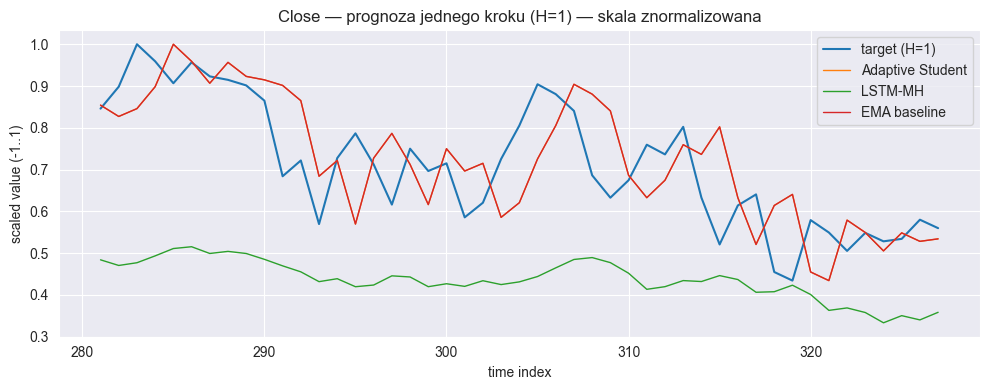

[Scaled] Student   | MAE=0.092968 | MAPE=0.141618
[Scaled] LSTM-MH   | MAE=0.275896 | MAPE=0.369512
[Scaled] EMA       | MAE=0.092968 | MAPE=0.141618


In [1399]:
import matplotlib.pyplot as plt
import numpy as np

# Rysujemy np. 'Close' = idx=1 (Open=0, Close=1, High=2, Low=3, trade_sign=4)
feature_name = 'Close'
idx = MH_FEATURES.index(feature_name)

# Wybieramy pierwszy horyzont (H=1 => h_index=0)
y_test_h1   = pick_horizon(Y_test_np, 0)       # (N, F)
y_stud_h1   = pick_horizon(Y_stud_np, 0)
y_lstm_h1   = pick_horizon(Y_lstm_np, 0)
y_ema_h1    = pick_horizon(Y_ema_np,  0)

# Oś czasu (doklejony do końca trainu, jak w Twoim przykładzie):
n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
x_axis = np.arange(n_train_old, n_train_old + y_test_h1.shape[0])

plt.figure(figsize=(10,4))
plt.plot(x_axis, y_test_h1[:, idx],  label='target (H=1)', lw=1.5)
plt.plot(x_axis, y_stud_h1[:, idx],  label='Adaptive Student', lw=1)
plt.plot(x_axis, y_lstm_h1[:, idx],  label='LSTM-MH', lw=1)
plt.plot(x_axis, y_ema_h1[:, idx],   label='EMA baseline', lw=1)
plt.title(f'{feature_name} — prognoza jednego kroku (H=1) — skala znormalizowana')
plt.xlabel('time index'); plt.ylabel('scaled value (-1..1)')
plt.legend()
plt.tight_layout()
plt.show()

# MAE/MAPE (w skali znormalizowanej)
for name, pred in [('Student', y_stud_h1), ('LSTM-MH', y_lstm_h1), ('EMA', y_ema_h1)]:
    mae, mape = mae_mape(pred[:, idx], y_test_h1[:, idx])
    print(f"[Scaled] {name:9s} | MAE={mae:.6f} | MAPE={mape:.6f}")


## Final Compariosn (yet without HCR-NN)

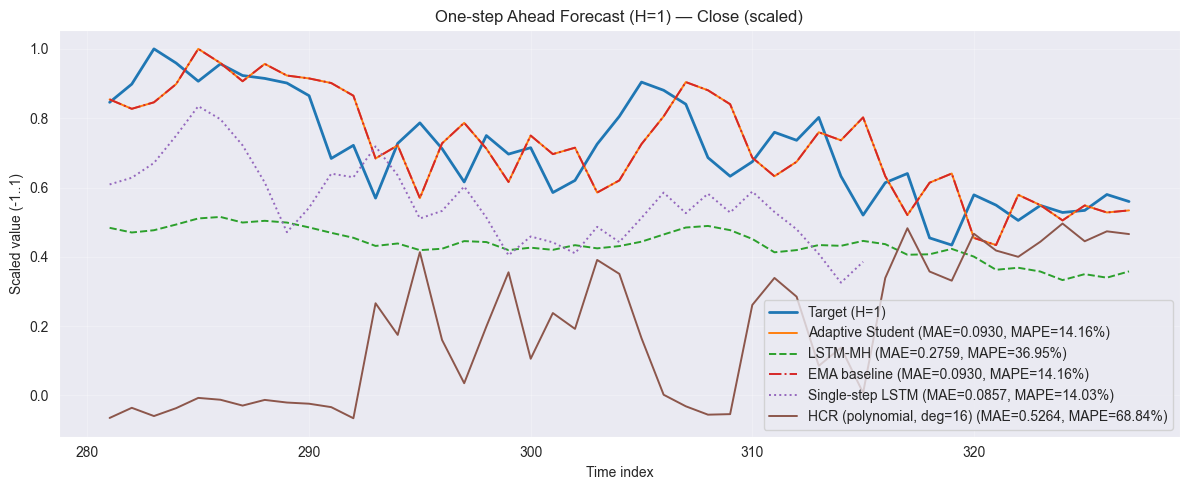

=== Scaled MAE/MAPE on H=1 — Close ===
Adaptive Student: MAE=0.092968, MAPE=0.141618
LSTM-MH        : MAE=0.275896, MAPE=0.369512
EMA baseline   : MAE=0.092968, MAPE=0.141618
Single-step LSTM: MAE=0.085743, MAPE=0.140346
HCR (polynomial, deg=16): MAE=0.526373, MAPE=0.688423


In [1400]:
# =======================
# Final Comparison Figure (z HCR)
# =======================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# ---- Config ----
feature_name = 'Close'  # zmień na dowolne z MH_FEATURES
f_idx = MH_FEATURES.index(feature_name)
h_index = 0             # H=1 => index 0
title = f"One-step Ahead Forecast (H=1) — {feature_name} (scaled)"

# ---- Helpers ----
def pick_horizon(Y, h_index: int):
    return Y[:, h_index, :]  # (N, F)

def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)))

# ---- Data: targets + predictions (scaled) ----
# Multi-horizon targets/preds
y_test_h1 = pick_horizon(Y_test_np, h_index)          # (N, F)
series = []  # (label, values_1d)

# Adaptive Student
y_stud_h1 = pick_horizon(Y_stud_np, h_index)
mae_s  = mean_absolute_error(y_test_h1[:, f_idx], y_stud_h1[:, f_idx])
mape_s = mape_safe(y_test_h1[:, f_idx], y_stud_h1[:, f_idx])
series.append((f"Adaptive Student (MAE={mae_s:.4f}, MAPE={mape_s:.2%})", y_stud_h1[:, f_idx]))

# LSTM-MH
y_lstm_h1 = pick_horizon(Y_lstm_np, h_index)
mae_l  = mean_absolute_error(y_test_h1[:, f_idx], y_lstm_h1[:, f_idx])
mape_l = mape_safe(y_test_h1[:, f_idx], y_lstm_h1[:, f_idx])
series.append((f"LSTM-MH (MAE={mae_l:.4f}, MAPE={mape_l:.2%})", y_lstm_h1[:, f_idx]))

# EMA baseline
y_ema_h1 = pick_horizon(Y_ema_np, h_index)
mae_e  = mean_absolute_error(y_test_h1[:, f_idx], y_ema_h1[:, f_idx])
mape_e = mape_safe(y_test_h1[:, f_idx], y_ema_h1[:, f_idx])
series.append((f"EMA baseline (MAE={mae_e:.4f}, MAPE={mape_e:.2%})", y_ema_h1[:, f_idx]))

have_single_step = ('y_pred_np' in globals()) and ('y_test_np' in globals()) and (y_test_np.ndim == 2)
if have_single_step:
    idx_old = 1  # Close w starej konwencji
    mae_o  = mean_absolute_error(y_test_np[:, idx_old], y_pred_np[:, idx_old])
    mape_o = mape_safe(y_test_np[:, idx_old], y_pred_np[:, idx_old])
    series.append((f"Single-step LSTM (MAE={mae_o:.4f}, MAPE={mape_o:.2%})", y_pred_np[:, idx_old]))

# ---- X-axis aligned with earlier plots ----
n_train_old = len(y_train_5_days_trade_sign) if 'y_train_5_days_trade_sign' in globals() else 0
N_test_len = y_test_h1.shape[0]
x_axis = np.arange(n_train_old, n_train_old + N_test_len)


have_hcr = ('u1_pred_scaled' in globals()) and ('u1_true_scaled' in globals())
if have_hcr:
    L = min(N_test_len, len(u1_pred_scaled))
    mae_h  = mean_absolute_error(y_test_h1[:L, f_idx], u1_pred_scaled[:L])
    mape_h = mape_safe(y_test_h1[:L, f_idx],           u1_pred_scaled[:L])

    basis_label = BASIS_NAME if 'BASIS_NAME' in globals() else 'cosine'
    deg_label   = DEGREE if 'DEGREE' in globals() else None
    label = f"HCR ({basis_label}" + (f", deg={deg_label}" if deg_label is not None else "") \
            + f") (MAE={mae_h:.4f}, MAPE={mape_h:.2%})"
    series.append((label, u1_pred_scaled[:L]))
else:
    print("[INFO] HCR: nie znaleziono u1_pred_scaled/u1_true_scaled. Uruchom wcześniej blok HCR (Twoja biblioteka).")

# ---- Plot ----
plt.figure(figsize=(12, 5))
# target (scaled)
plt.plot(x_axis, y_test_h1[:, f_idx], label="Target (H=1)", linewidth=2.0)

# modele
linestyles = ['-', '--', '-.', ':']  # rotacja stylów
for i, (lbl, vals) in enumerate(series):
    if len(vals) != N_test_len:
        L = min(len(vals), N_test_len)
        plt.plot(x_axis[:L], vals[:L], label=lbl, linestyle=linestyles[i % len(linestyles)], linewidth=1.4)
    else:
        plt.plot(x_axis, vals, label=lbl, linestyle=linestyles[i % len(linestyles)], linewidth=1.4)

plt.title(title)
plt.xlabel("Time index")
plt.ylabel("Scaled value (-1..1)")
plt.grid(alpha=0.25)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

# ---- Compact metrics table ----
print("=== Scaled MAE/MAPE on H=1 —", feature_name, "===")
print(f"Adaptive Student: MAE={mae_s:.6f}, MAPE={mape_s:.6f}")
print(f"LSTM-MH        : MAE={mae_l:.6f}, MAPE={mape_l:.6f}")
print(f"EMA baseline   : MAE={mae_e:.6f}, MAPE={mape_e:.6f}")
if have_single_step:
    print(f"Single-step LSTM: MAE={mae_o:.6f}, MAPE={mape_o:.6f}")
if have_hcr:
    print(f"HCR ({basis_label}, deg={deg_label}): MAE={mae_h:.6f}, MAPE={mape_h:.6f}")
